<a href="https://colab.research.google.com/github/YunJiye/project_Pzone/blob/vision/PZONE_%EB%B9%84%EC%A0%84_%ED%86%B5%EC%8B%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구글 드라이브 연결

In [1]:
# multipart/form-data 형식으로 주고 받는 데이터를 인코딩하기 위해 설치
!pip install requests_toolbelt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.0 MB/s 


In [2]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

from requests_toolbelt import MultipartEncoder
import requests
import json

import datetime as dt
import smtplib
from email.mime.text import MIMEText
#from glob import glob
import glob
from dataclasses import dataclass 
from google.colab import drive
from google.colab.patches import cv2_imshow
import random
import cv2
import os
import csv
import time
import numpy as np
from queue import Queue
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
#from glob import glob
import shutil
import os, glob, shutil

url = "http://43.200.203.0:8080"

Mounted at /content/drive


In [3]:
def check_res(response):
  if response.status_code == 200: 
    print("Success")
  elif response.status_code == 400:
    print("Not Found")
  elif response.status_code == 302:
    print("Follow Redirect")
  elif response.status_code == 302:
    print("Not Authorized")
  print(response.text)
    


def post(api, field_data):
  m = MultipartEncoder(fields=field_data)
  headers = {'Content-Type':m.content_type}
  res = requests.post(url+api, headers=headers, data=m)
  print(check_res(res))
  return res.status_code, res.json()



# 최종 이미지 생성 함수(construct_img()) - 박태윤

In [4]:
@dataclass
class DOT:
  row: int = None
  col: int = None
  number: int = None


global map, tmp_map, parking_map, comment, rowSize, colSize, startX, startY, parkingPlace, road, emptyFlag, direction, numOfPP, ppIdx, dx, dy, visit, initialBox, mappingBox, cntPP
map = [['z' for col in range(1001)] for row in range(1001)]
tmp_map = [['z' for col in range(1001)] for row in range(1001)]
parking_map = [[["z" for idx1 in range(1001)] for idx2 in range(1001)] for idx3 in range(100)]
comment = ["none" for idx in range(1001)]
rowSize = 0; colSize = 0;
i = 0; j = 0;
#입구 위치
startX = 0; startY = 0;
#주차 공간 정보
parkingPlace = [DOT() for idx in range(1001)]
road = [list() for idx in range(1001)]
emptyFlag = ['z' for i in range(1001)] # "a"면 빈칸 "A"면 차있는 칸
direction = ['z' for i in range(1001)]
numOfPP = 0
ppIdx = 0
dx = [1,-1,0,0]
dy = [0,0,1,-1]

visit = [[0 for col in range(1001)]for row in range(1001)]

#초기 디텍팅박스 좌표 정보
initialBox = []
mappingBox = []

#cctv 담당 구역 개수(초기 정보)
cntPP  = [4,4,4,4,4,4,5,4,5,4]

def initBox():
  tmpInit = []
  initialBox.clear()
  print("initialBox : ", initialBox)
  #수정
  for i in range(10):
    f = open("/content/drive/MyDrive/empty/labels/001_" + chr(ord("A") + i)+".txt", 'r')
    tmpList = []
    while True:
      line = f.readline()

      if not line:break

      e,a,b,c,d = line.split()

      e=int(e)
      a=float(a)
      b=float(b)
      c=float(c)
      d=float(d)

      tmpList.append(e)
      tmpList.append(a)
      tmpList.append(b)
      tmpList.append(c)
      tmpList.append(d)

    initialBox.append(tmpList)



  f = open("/content/drive/MyDrive/textData/parkingArea.txt", 'r')
  
  while True:
    line = f.readline()

    if not line:break

    x = line.split()

    for i in range(1, len(x)):
      x[i] = int(x[i])

    mappingBox.append(x)

  f.close()

def makeTXT():
  #elem => A구역부터 차량 여부(1, 0)와 디텍팅 박스 좌표 정보
  #mappingBox를 통해 (방향, 좌표1, 좌표2....) 차량 여부를 써줘야함.
  idx = 0
  #print("initialBox : ", initialBox)
  for elem in initialBox:
    mapIdx = 1
    for i in range(0, len(elem), 5):
      if elem[i] == 1:
        #제대로 된 mapIdx 찾아주기
        #cctv가 4대의 주차구역을 담당
        calList = []

        #print("idx : ", idx)

        if cntPP[idx] == 4:
          for j in range(1,5):
            calList.append(abs(0.1*j*2-elem[i+1]))
   
        #cctv가 5대의 주차구역을 담당
        elif cntPP[idx] == 5:
          for j in range(1,10,2):
            calList.append(abs(0.1*j-elem[i+1]))

        mapIdx = calList.index(min(calList))
        mapIdx = mapIdx*2+1

        x = mapIdx
        y = mapIdx+1
        map[mappingBox[idx][x]][mappingBox[idx][y]] = "A"

        if mappingBox[idx][0] == "d":
          map[mappingBox[idx][x]+1][mappingBox[idx][y]] = "A"
          map[mappingBox[idx][x]+2][mappingBox[idx][y]] = "A"
        elif mappingBox[idx][0] == "l":
          map[mappingBox[idx][x]][mappingBox[idx][y]-1] = "A"
          map[mappingBox[idx][x]][mappingBox[idx][y]-2] = "A"
      
      #mapIdx += 2

      #elif elem[i] == 0:


    idx += 1

def searchRoad(idx, x, y, cost):
  road[idx].append(DOT(row = x, col = y, number = -1))
  while(True):
    for k in range(4):
      nx = x + dx[k]
      ny = y + dy[k]

      if nx < 0 or ny < 0 or nx > rowSize or ny > colSize : continue
      if visit[nx][ny] == cost-1:
        road[idx].append(DOT(row = nx, col = ny, number = -1))
        x = nx
        y = ny
        cost  -= 1
        break
    
    if cost <= 1 : break


def bfs(num):
  for i in range(rowSize+1):
    for j in range(colSize+1):
      tmp_map[i][j] = map[i][j]
      visit[i][j] = 0

  #q = list()
  q = Queue()
  #q.append((startX, startY, 1))
  q.put((startX, startY, 1))

  visit[startX][startY] = 1

  dirIdx = 0

  while q.empty() == False:
    tmp = q.get()
    x = tmp[0]
    y = tmp[1]
    cost = tmp[2]

    for k in range(4):
      nx = x + dx[k]
      ny = y + dy[k]

      if (nx < 0) or (ny < 0) or (nx > rowSize) or (ny > colSize) : continue
      if (tmp_map[nx][ny] == 'd') or (tmp_map[nx][ny] == 'e') or (tmp_map[nx][ny] == 'f') or (tmp_map[nx][ny] == 'z') : continue
      if visit[nx][ny] >= 1 : continue

      visit[nx][ny] = cost + 1
      q.put((nx,ny,cost+1))

      if tmp_map[nx][ny] == 'a' or tmp_map[nx][ny] == 'A':
        for t in range(1001):
          if parkingPlace[t].row == None:
            parkingPlace[t].row = nx
            parkingPlace[t].col = ny
            #parkingPlace[ppIdx].number = ppIdx
            parkingPlace[t].number = t
            emptyFlag[t] = tmp_map[nx][ny]
            dirIdx = t
            break

        #searchRoad(ppIdx, nx, ny, cost+1)
        searchRoad(t, nx, ny, cost+1)

        map[nx][ny] = 'f'

        for l in range(4):
          px = nx + dx[l]
          py = ny + dy[l]

          if px < 0 or py < 0 or px > rowSize or py > colSize : continue

          if tmp_map[px][py] == 'a' or tmp_map[px][py] == 'A':
            if l == 0:
              direction[dirIdx] = 'd'
            elif l == 1:
              direction[dirIdx] = 'u'
            elif l == 2:
              direction[dirIdx] = 'r'
            elif l == 3:
              direction[dirIdx] = 'l'
            map[px][py] = 'f'
            map[px+dx[l]][py+dy[l]] = 'f'

            break
      
        #q.clear()
        return

def printMap(m):
  for i in range(rowSize+1):
    for j in range(colSize+1):
      print(m[i][j], end = "")
    print()

def printParkingPlace():
  for i in range(numOfPP):
    print(parkingPlace[i].row, parkingPlace[i].col, parkingPlace[i].number, emptyFlag[i])

def printRoad(idx):
  print("parkingPlace :", parkingPlace[idx].row, parkingPlace[idx].col)
  
  for i in range(len(road[idx])):
    print(road[idx][i][0], road[idx][i][1])

def makeTXTRoad(idx):
  f = open("road.txt", "w")

  tmpStr = "parkingPlace :" + str(parkingPlace[idx].row) + " " + str(parkingPlace[idx].col) + "\n"
  f.write(tmpStr)
  
  for i in range(len(road[idx])):
    tmpStr = str(road[idx][i].row) + " " + str(road[idx][i].col) + "\n"
    f.write(tmpStr)

  f.close()

def makeComment():
  for idx in range(numOfPP):
    dIdx = 3
    nx = startX + dx[dIdx]
    ny = startY + dy[dIdx]
    num = 2
    flag = 0
    tmp_com = ""

    while parking_map[idx][nx][ny] != 'U':
      #print(parking_map[idx][nx][ny])
      if parking_map[idx][nx + dx[dIdx]][ny + dy[dIdx]] == 'P' : num += 2
      else:
        tmp_com += "전방으로 약" + str(num) + "미터 직진 후 "
        num = 2

        for k in range(4):
          cx = nx + dx[k]
          cy = ny + dy[k]

          if cx < 0 or cy < 0 or cx > rowSize or cy > colSize : continue
          if parking_map[idx][cx][cy] == 'U' :
            tmp_com += "\n주차 공간 도착입니다. \n"
            comment[idx] = tmp_com
            flag = 1
            break
        

        if flag == 0:
          if dIdx == 3:
            if parking_map[idx][nx+dx[0]][ny+dy[0]] == 'P':
              dIdx = 0; tmp_com += "좌회전 입니다. \n이어서 "
            elif parking_map[idx][nx+dx[1]][ny + dy[1]] == 'P':
              dIdx = 1; tmp_com += "우회전 입니다. \n이어서 "
          elif dIdx == 2:
            if parking_map[idx][nx+dx[0]][ny+dy[0]] == 'P':
              dIdx = 0; tmp_com += "우회전 입니다. \n이어서 "
            elif parking_map[idx][nx+dx[1]][ny + dy[1]] == 'P':
              dIdx = 1; tmp_com += "좌회전 입니다. \n이어서 "
          elif dIdx == 1:
            if parking_map[idx][nx+dx[2]][ny+dy[2]] == 'P':
              dIdx = 2; tmp_com += "좌회전 입니다. \n이어서 "
            elif parking_map[idx][nx+dx[3]][ny + dy[3]] == 'P':
              dIdx = 3; tmp_com += "우회전 입니다. \n이어서 "
          elif dIdx == 0:
            if parking_map[idx][nx+dx[2]][ny+dy[2]] == 'P':
              dIdx = 2; tmp_com += "우회전 입니다. \n이어서 "
            elif parking_map[idx][nx+dx[3]][ny + dy[3]] == 'P':
              dIdx = 3; tmp_com += "좌회전 입니다. \n이어서 "
        else : break
      nx = nx + dx[dIdx]; ny = ny + dy[dIdx]
    

def makeRoadMap():
  for idx in range(numOfPP):
    one = parkingPlace[idx]
    map[one.row][one.col] = 'U'

    for k in range(4):
      nx = one.row + dx[k]
      ny = one.col + dy[k]

      if nx < 0 or ny < 0 or nx > rowSize or ny > colSize : continue
      if map[nx][ny] == 'f':
        two = DOT(row = nx, col = ny, number = -1)
        three = DOT(row = nx + dx[k], col = ny + dy[k], number = -1)
    
    map[two.row][two.col] = 'U'
    map[three.row][three.col] = 'U'

    for k in range(1, len(road[idx])-1):
      map[road[idx][k].row][road[idx][k].col] = 'P'
    
    for i in range(rowSize+1):
      for j in range(colSize+1):
        parking_map[idx][i][j] = map[i][j]
    
    for k in range(1, len(road[idx]) - 1):
      map[road[idx][k].row][road[idx][k].col]  = '0'

    map[one.row][one.col] = 'f'
    map[two.row][two.col] = 'f'
    map[three.row][three.col] = 'f'

def construct_img(p,section):

  global map, tmp_map, parking_map, comment, rowSize, colSize, startX, startY, parkingPlace, road, emptyFlag, direction, numOfPP, ppIdx, dx, dy, visit, initialBox, mappingBox, cntPP

  #test_img = glob('/content/drive/MyDrive/주차장/Images/*.jpg')+glob('/content/drive/MyDrive/주차장/Images/*.jpeg')
  for test_imt in test_img:
    !python /content/drive/MyDrive/yolov5/detect.py --weights /content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt --img 320 --conf 0.5 --source {test_imt} --save-txt

  dir = '/content/drive/MyDrive/yolov5/runs/detect/**'
  filelist = glob.glob(dir, recursive = True)
  file_list_txt = [file for file in filelist if file.endswith(".txt")]

  change_file_list = []

  for file in file_list_txt:
    txtFile = open(file, "r")
    tmp = file

    idx = 0

    for i in range(len(tmp)-1, 0, -1):
      if tmp[i] == "/":
        idx = i
        break

    tmp = tmp[idx+1 : len(file)]

    resStr = ""
    while True:
      coor = txtFile.readline()
      tupleCoor = coor.split()

      if not coor: break

      width = float(tupleCoor[3])

      if width < 0.1 : 
        print(coor)
        continue
      else: resStr += coor

    #change_file_list.append((tmp, txtFile.read()))
    change_file_list.append((tmp, resStr))


  print(change_file_list)

  drive.mount('/content/drive', force_remount = True)

  #모두 비어있을 때의 좌표 구축
  initBox()

  f = open("/content/drive/MyDrive/textData/parking.txt", 'r', encoding = 'cp949')

  #들어온 이미지에 대해 좌표값 변경
  #chg_file
  for obj in change_file_list:
    chg_file = open("/content/drive/MyDrive/empty/labels/" + obj[0], "w")
    chg_file.write(obj[1])

  chg_file.close()

  for i in range(1000):
    for j in range(1000):
      map[i][j] = 'z'

  i = 0; j = 0

  numOfPP = int(f.readline())

  c = f.read()

  for k in range(len(c)):
    if c[k] == '\n':
      j = 0; i+=1; continue
    
    if c[k] == 'c':
      startX = i; startY = j

    map[i][j] = c[k]
    j += 1

    rowSize = max(i, rowSize)
    colSize = max(j, colSize)

  #주차공간마다 차량 여부 맵핑
  makeTXT()

  for n in range(numOfPP):
    bfs(n)

  makeRoadMap();
  makeComment();

  wfp = open("parkingPlace.txt", "w")

  for i in range(numOfPP):
      tmpStr = str(parkingPlace[i].row) + " " + str(parkingPlace[i].col) + " " + str(parkingPlace[i].number) + " " + str(emptyFlag[i]) + " " + direction[i] + "\n"
      wfp.write(tmpStr)

  fcom = open("comment.txt", "w")

  for i in range(numOfPP):
    if emptyFlag[i] == 'a':
      #print("Sssssssssssssssssssssssssssss")
      makeTXTRoad(i)
      fcom.write(comment[i])
      break


  fcom.close()
  f.close()
  wfp.close()

  class dot:
    row: int = None
    col: int = None
    number: int = None
    flag: int = None #이미 주차되어 있는지 여부
    direc : str = None

  fp = open("parkingPlace.txt", "r")
  fp2 = open("road.txt", "r")

  line = fp2.readline()
  line = line[14:]
  a, b = line.split()
  a = int(a); b= int(b)

  parkingMap = [dot() for i in range(int(1001))]

  idx = 0

  while True:
      line = fp.readline()
      if not line: break
      row, col, number, flag, direc = line.split()
      parkingMap[idx].row = int(row)
      parkingMap[idx].col = int(col)
      parkingMap[idx].number = int(number)
      parkingMap[idx].direc = direc
      if flag == "A":
          parkingMap[idx].flag = 1
      elif flag == 'a':
          parkingMap[idx].flag = 0
      idx+=1

  #txt파일에서 주차 공간 중 a로 되어 있는 곳은 빈 주차 공간, A로 되어 있는 곳은 주차가 이미 되어 있는 공간

  img = np.full((1500,1500,3), 255, np.uint8)

  #주차장 라인
  cv2.line(img, (320, 150), (320, 415), (170,170,170), 7)

  cv2.line(img, (110, 110), (95, 110), (200,200,200), 3)
  cv2.arrowedLine(img, (95,110), (95,130), (200,200,200), 3, tipLength = 0.5)

  cv2.line(img, (95, 445), (95, 460), (200,200,200), 3)
  cv2.arrowedLine(img, (95,460), (115,460), (200,200,200), 3, tipLength = 0.5)

  cv2.line(img, (260, 460), (280, 460), (200,200,200), 3)
  cv2.arrowedLine(img, (280,460), (280,440), (200,200,200), 3, tipLength = 0.5)
  cv2.arrowedLine(img, (280,460), (300,460), (200,200,200), 3, tipLength = 0.5)

  cv2.line(img, (300, 110), (280, 110), (200,200,200), 3)
  cv2.arrowedLine(img, (280,110), (280,130), (200,200,200), 3, tipLength = 0.5)
  cv2.arrowedLine(img, (280,110), (260,110), (200,200,200), 3, tipLength = 0.5)


  #주차장 그리기
  for i in range(1001):
      if a == parkingMap[i].row and b == parkingMap[i].col:
          color = (203, 199, 255)
          colorFlag = -1
      else:
          if parkingMap[i].flag == 1:
              color = (255,157,106)
              colorFlag = -1
          else:
              color = (255,157,106)
              colorFlag = 2

      if parkingMap[i].row == None: break
      else:
          if parkingMap[i].direc == "u":
              cv2.rectangle(img, (
              parkingMap[i].col * 15+10,
                  parkingMap[i].row * 15),(parkingMap[i].col*15 + 30,parkingMap[i].row*15 + 30),
                            color, colorFlag)

          elif parkingMap[i].direc == "d":
              cv2.rectangle(img, (
              parkingMap[i].col * 15+10,
                  parkingMap[i].row * 15+25), (parkingMap[i].col*15 + 30, parkingMap[i].row*15 + 55),
                            color, colorFlag)

          elif parkingMap[i].direc == "l":
              cv2.rectangle(img, (
              parkingMap[i].col * 15+20,
                  parkingMap[i].row * 15+20), (parkingMap[i].col*15 - 10, parkingMap[i].row*15 + 40),
                            color, colorFlag)
          
          elif parkingMap[i].direc == "r":
              cv2.rectangle(img, (
              parkingMap[i].col * 15+20,
                  parkingMap[i].row * 15+40), (parkingMap[i].col*15 +50, parkingMap[i].row*15 +20),
                            color, colorFlag)

  for i in range(1001):
      if a == parkingMap[i].row and b == parkingMap[i].col:
          ch = parkingMap[i].direc
          break

  roadList = []

  while True:
      line = fp2.readline()

      if not line: break

      a,b = line.split()
      a = int(a); b = int(b)

      roadList.append((a,b))

  roadList.reverse()

  if ch == 'd':
      del roadList[len(roadList)-1]

  for i in range(len(roadList)-1):
      a, b = roadList[i]
      c, d = roadList[i+1]
      if ch == 'u':
          if i == len(roadList)-2:
              cv2.arrowedLine(img, (b * 15 + 5+15, a * 15 + 30), (d * 15 + 5+15, c * 15 + 30), (0, 0, 255), 3, tipLength = 0.5)
          else:
              cv2.line(img, (b*15+5+15,a*15+30), (d*15+5+15,c*15+30), (0,0,255), 3)
      elif ch == 'l':
          if i == len(roadList)-2:
              cv2.arrowedLine(img, (b * 15 + 5+15, a * 15 + 5+25), (d * 15 + 5+15, c * 15 + 5+25), (0, 0, 255), 3, tipLength = 0.5)
          else:
              cv2.line(img, (b*15+5+15,a*15+5+25), (d*15+5+15,c*15+5+25), (0,0,255), 3)
      elif ch == 'r':
          if i == len(roadList)-2:
              cv2.arrowedLine(img, (b * 15 + 5+10, a * 15 + 5+25), (d * 15 + 5+10, c * 15 + 5+25), (0, 0, 255), 3, tipLength = 0.5)
          else:
              cv2.line(img, (b * 15+5+10, a * 15 + 5+25), (d * 15 + 5+10, c * 15 + 5+25), (0, 0, 255), 3)
      elif ch == 'd':
          if i == len(roadList)-2:
              cv2.arrowedLine(img, (b * 15 + 5 + 15, a * 15 + 20 + 15), (d * 15 + 5 + 15, c * 15 + 20+15), (0, 0, 255), 3, tipLength = 0.5)
          else:
              cv2.line(img, (b*15+5 + 15, a*15+20+15), (d*15+5 + 15, c*15+20+15), (0,0,255), 3)

  cv2.line(img, (10, 550), (320, 550), (255,157,106), 3)


  cv2_imshow(img)
  cv2.imwrite("Image.jpg", img)
  cv2.waitKey()
  cv2.destroyAllWindows()

  fp.close()
  fp2.close()

  fontsize = 16
  fnt = ImageFont.truetype("/content/drive/MyDrive/textData/NanumGothic.ttf", fontsize)
  img = Image.open("/content/Image.jpg")
  draw = ImageDraw.Draw(img)

  # 텍스트 위치 설정을 위해 이미지 사이즈를 도출합니다.
  w, h = img.size

  txt_file = open("comment.txt", "r")
  text = txt_file.read()
  txt_file.close()

  #text = "샘플 글자"

  w_txt, h_txt = draw.textsize(text, fnt)

  margin = 500
  x = w - w_txt - 1200
  y = h - h_txt - 850
  draw.text((x,y), text, fill = 'black', font = fnt)

  img.show()
  #고쳐도 되는거야??
  #file_name = p['id']+'_'+3+'_'+0+'_'+section+'.jpg'
  file_name = str(p['id'])+'_'+'3'+'_'+'1'+'_'+section+'.jpg'
  img.save(file_name)

  saveImg = cv2.imread(file_name)

  saveImg = saveImg[0:660, 0:330]

  cv2.imwrite("/content/drive/MyDrive/주차장/전송/"+file_name, saveImg)

# 테스트용 설계도면 추가 코드


In [5]:
#files = {'uploadFile': open('/content/drive/MyDrive/설계도1.jpg','rb')}
#{'client': 'owner_1_token', 'name': 'parkingLot_1', 'address': 'parkingLot_1_address', 'latitude': 12.3, 'longitude': 45.6, 'cars': [], 'numberOfCars': 0, 'id': 1}

#r=requests.post(url+'/parking_lot_registration',files=files, params={'owner_id':'owner_2_token', 'name': 'parkingLot_2',  'address': 'parkingLot_2_address', 'latitude': 12.3, 'longitude': 45.6})
#check_res(r)
#파일명은 [주차장]_*[파일타입(enum)]_*[구역]으로 다시 저장

#enum FILE_TYPE{NOTHING, CCTV_PICTURE, CCTV_VIDEO, PARKINGLOT_SKETCH, PARKINGLOT_DRAWING};

In [6]:
#data = requests.get(url+"/download",params={'parkingLotID':1, 'fileType':1, 'section':'A'})

# 백엔드와의 통신파트


file_list ['/content/drive/MyDrive/drowing/', '/content/drive/MyDrive/drowing/parkingLot_1_1.jpg', '/content/drive/MyDrive/drowing/parkingLot_3_3.jpg', '/content/drive/MyDrive/drowing/sample_12.jpg', '/content/drive/MyDrive/drowing/parkingLot_2_11.jpg', '/content/drive/MyDrive/drowing/parkingLot_1_10.jpg', '/content/drive/MyDrive/drowing/sample_14.jpg', '/content/drive/MyDrive/drowing/sample_13.jpg', '/content/drive/MyDrive/drowing/sample2_15.jpg', '/content/drive/MyDrive/drowing/parkingLot_2_16.jpg', '/content/drive/MyDrive/drowing/parkingLot_2_17.jpg', '/content/drive/MyDrive/drowing/test test_19.jpg', '/content/drive/MyDrive/drowing/test_20.jpg', '/content/drive/MyDrive/drowing/test_18.jpg', '/content/drive/MyDrive/drowing/test_21.jpg', '/content/drive/MyDrive/drowing/test_sample_22.jpg']
주차장 목록(owner 있는 등록된 주차장)
 [{'client': 'owner_1_token', 'name': 'parkingLot_1', 'address': 'parkingLot_1_address', 'latitude': 12.3, 'longitude': 45.6, 'cars': [], 'numberOfCars': 0, 'id': 1}, {'cli

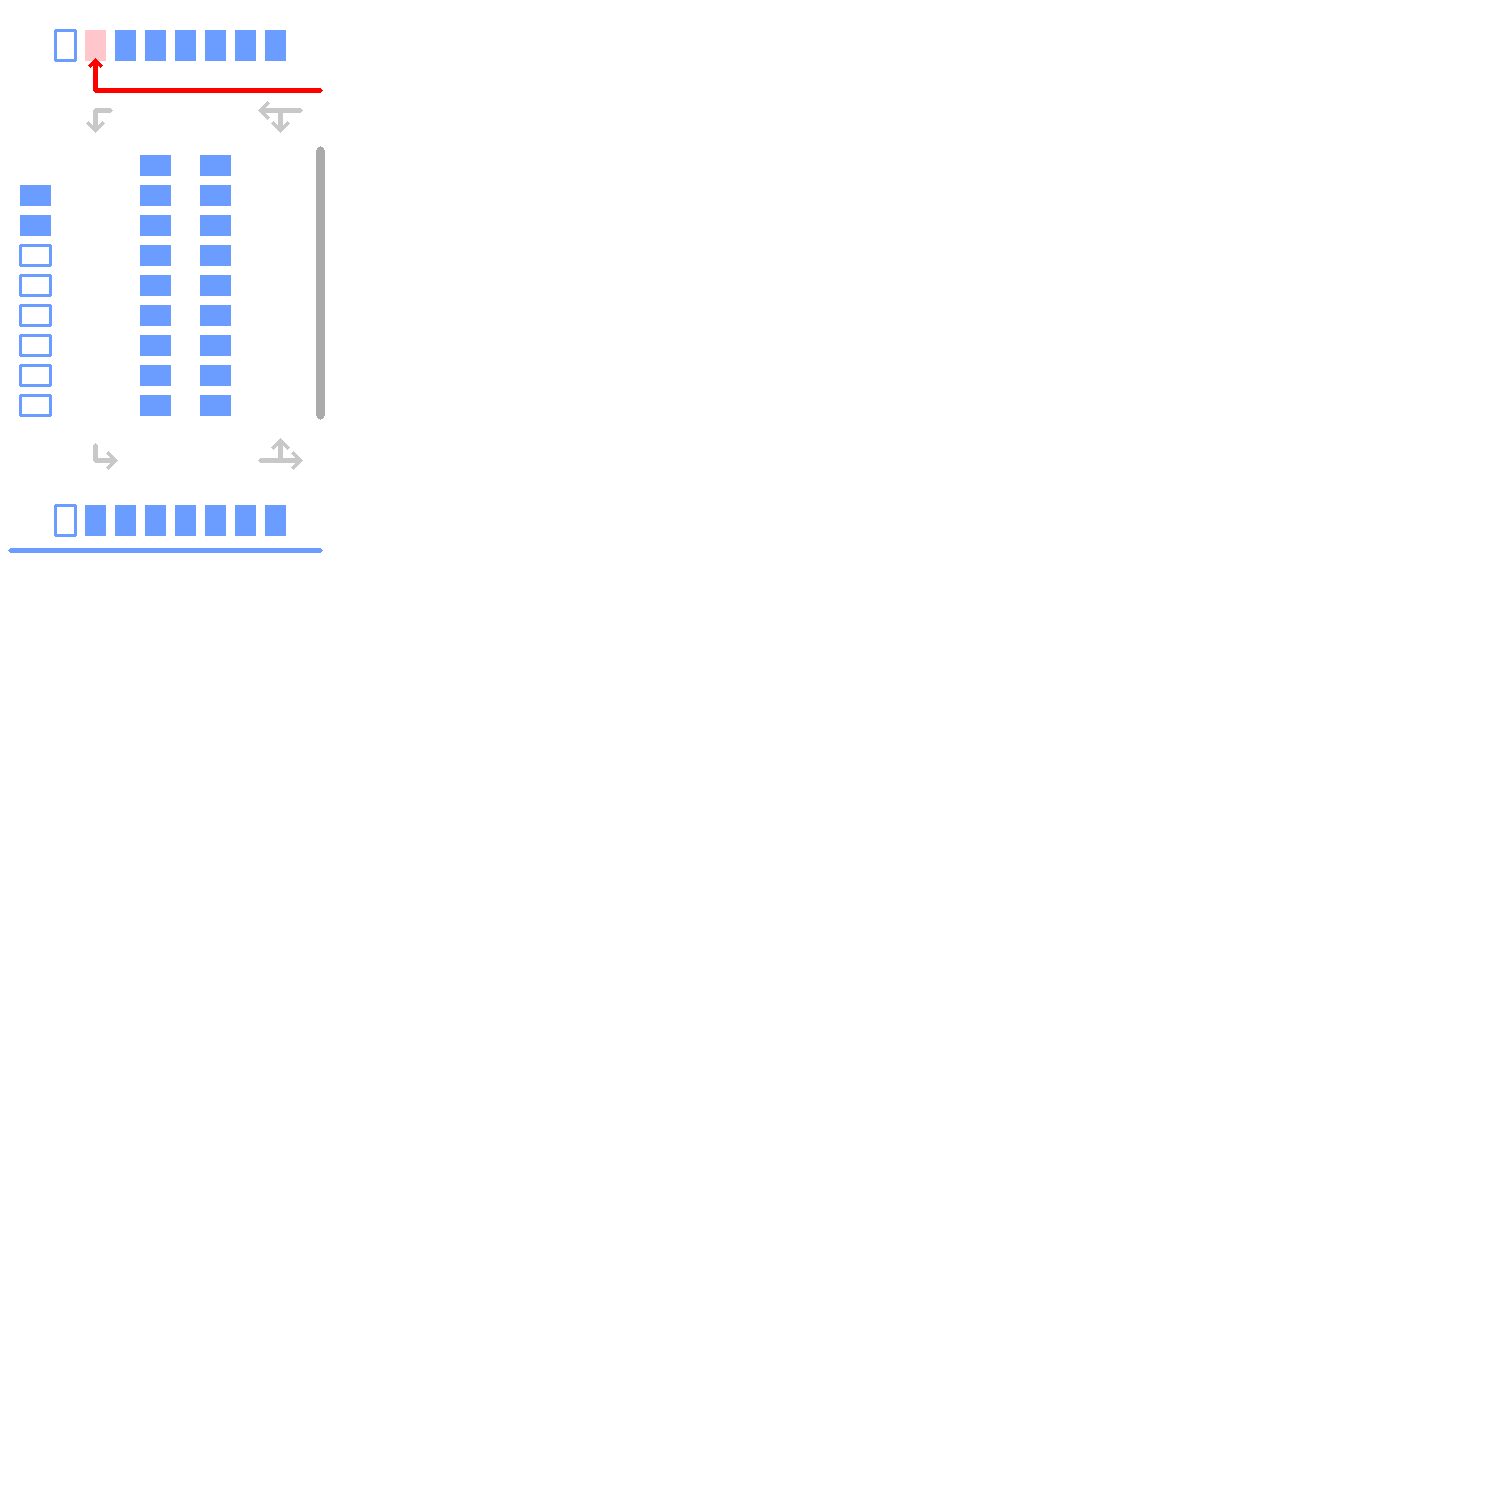

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 29.0ms
Speed: 0.2ms pre-process, 29.0ms inference, 1.4ms NMS

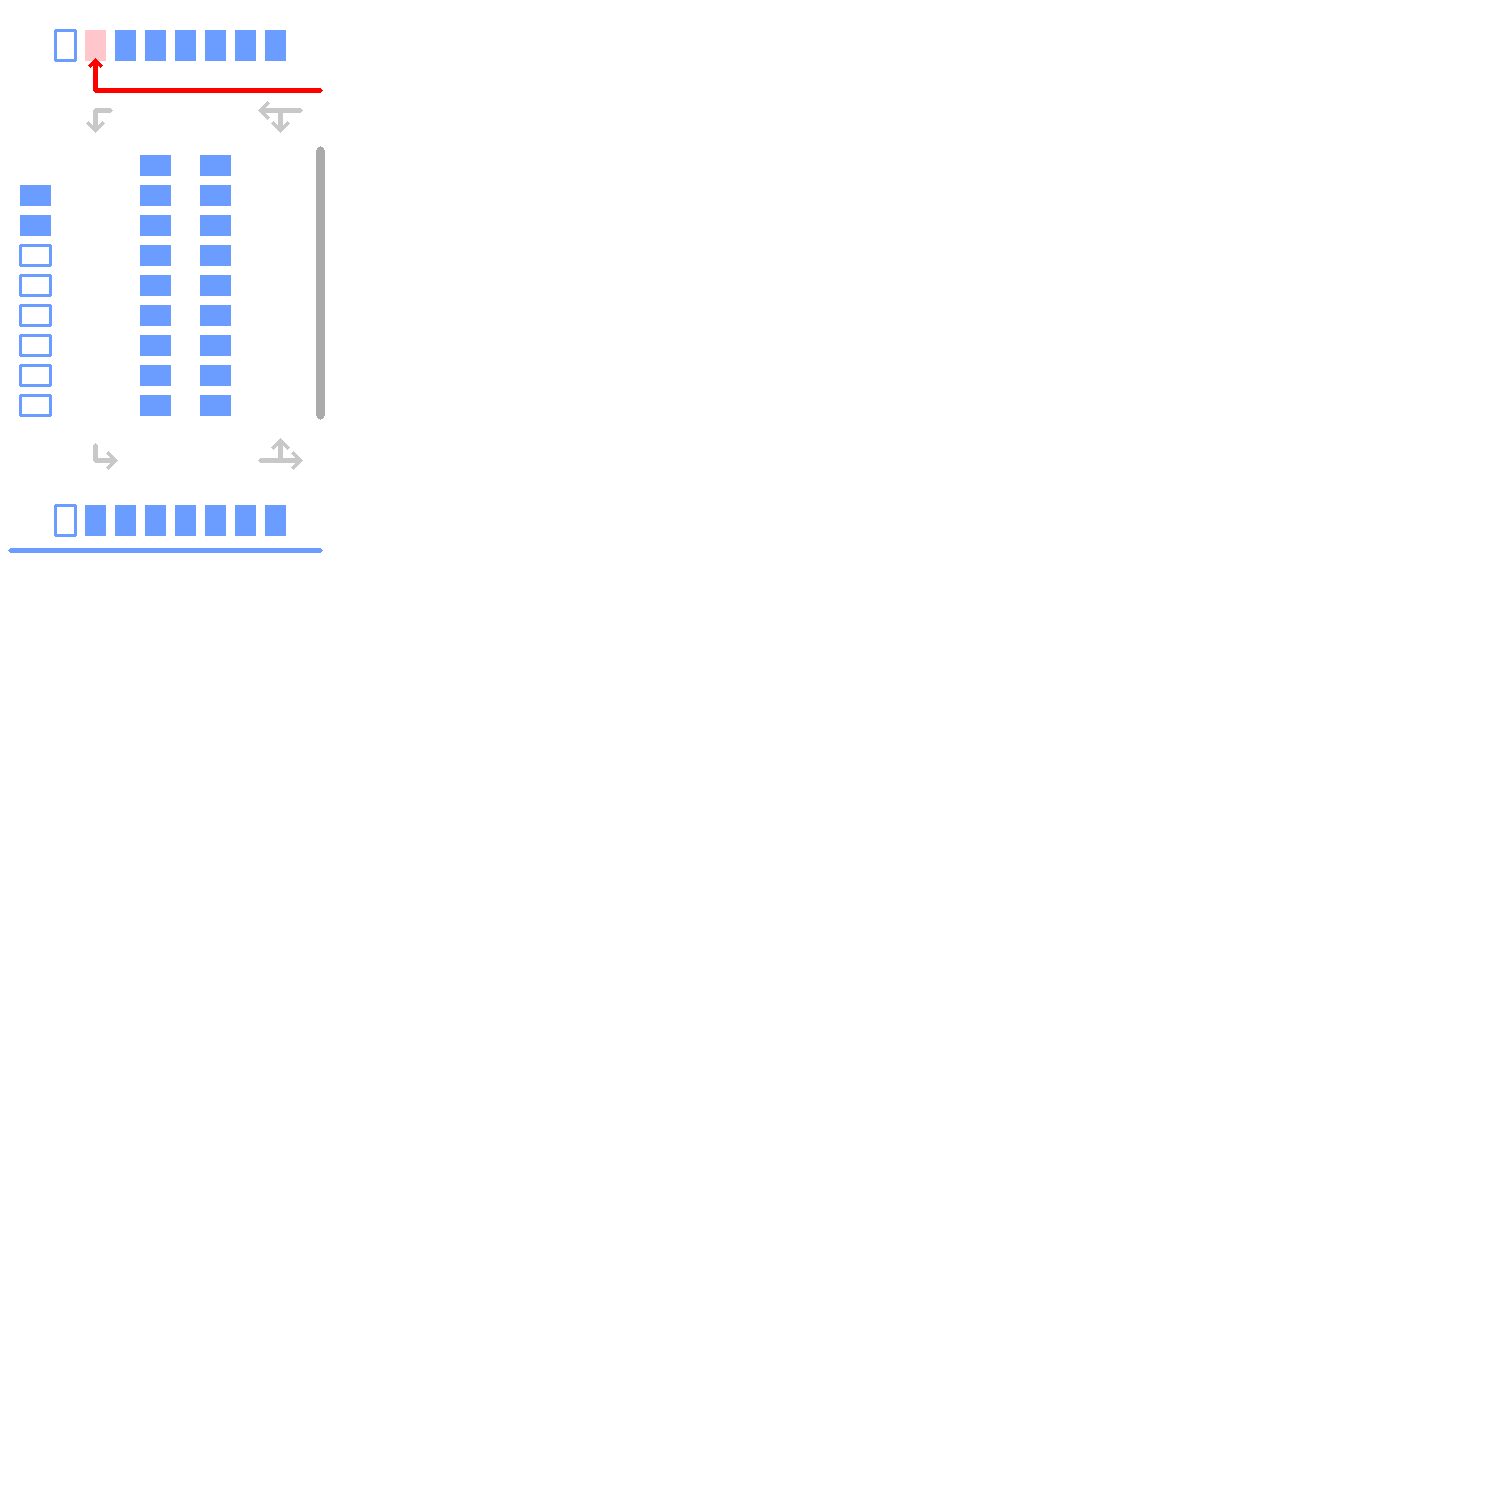

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 28.9ms
Speed: 0.3ms pre-process, 28.9ms inference, 1.4ms NMS

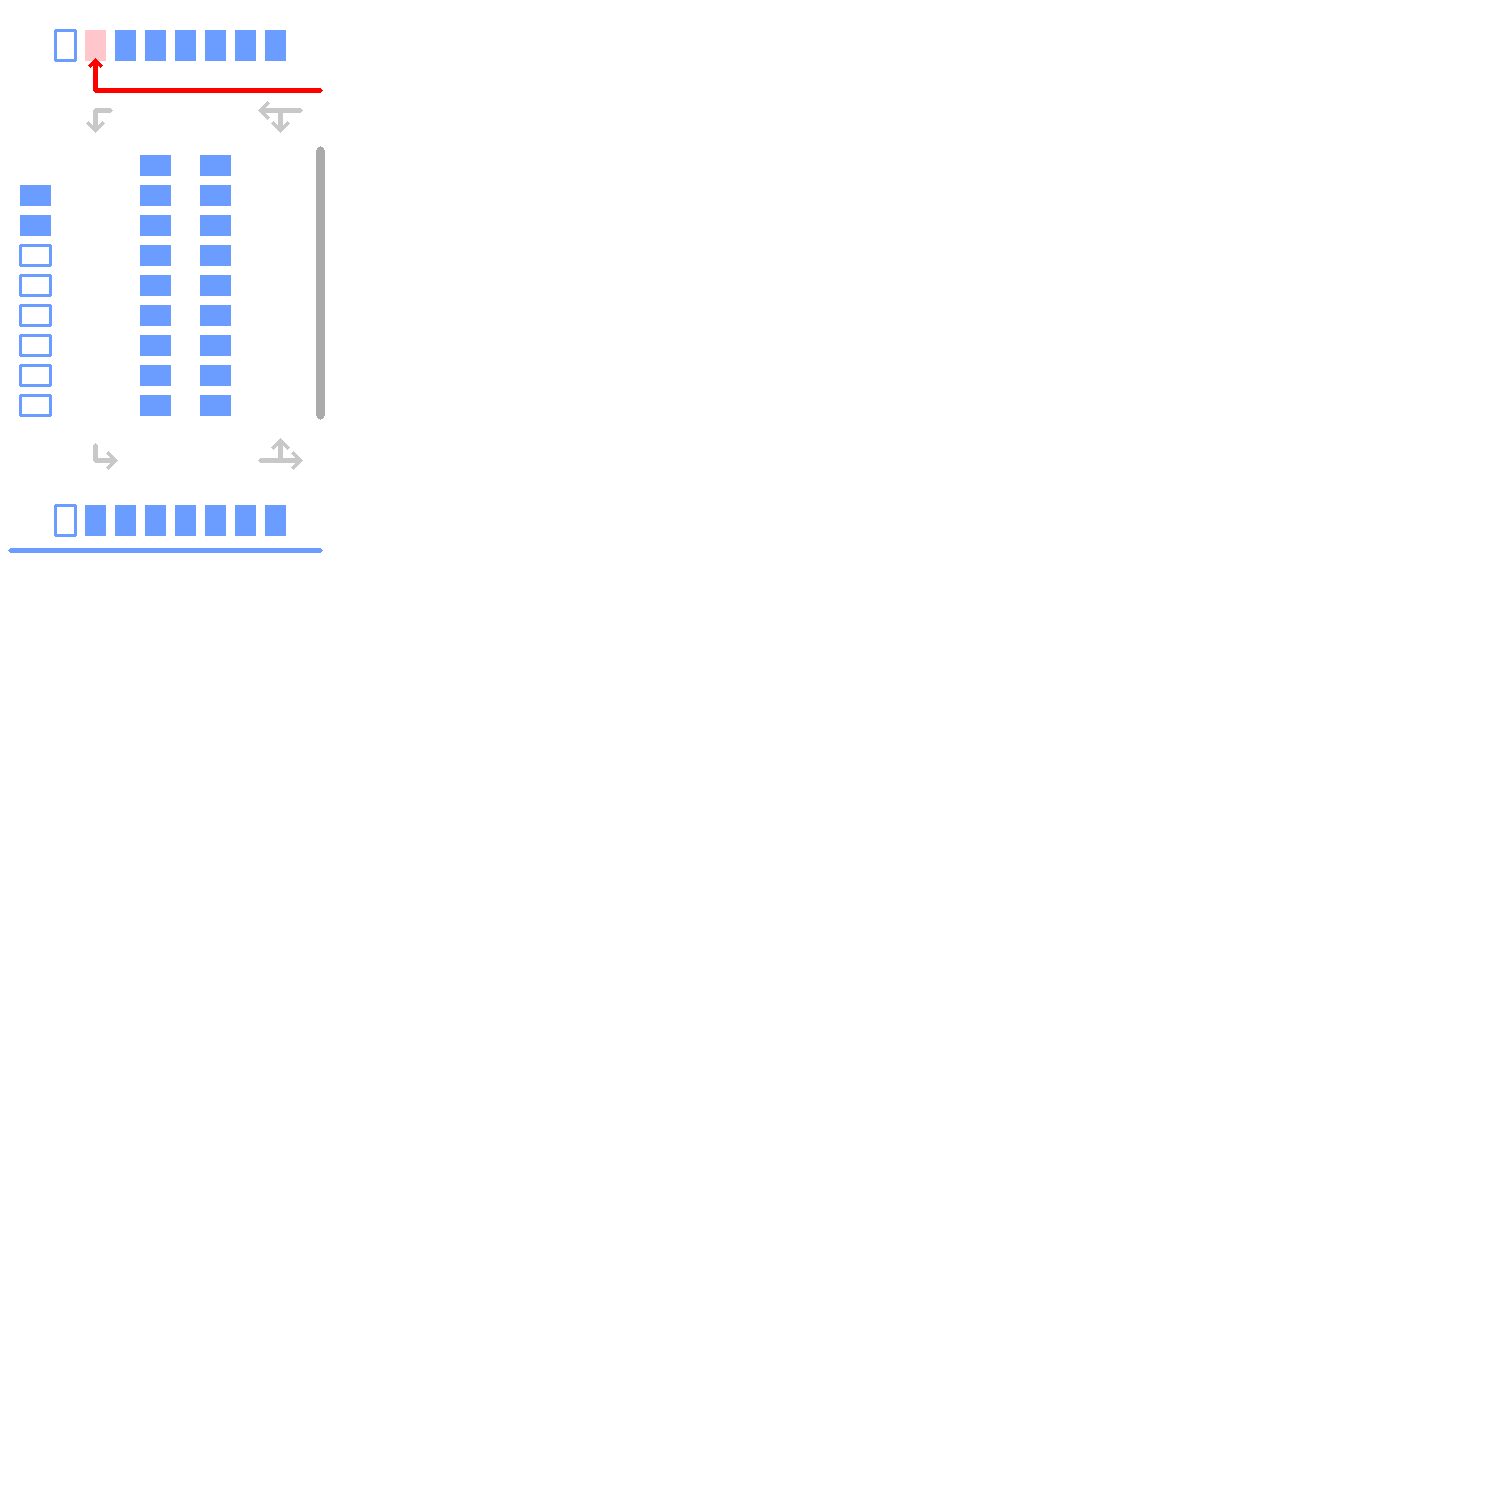

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 28.9ms
Speed: 0.3ms pre-process, 28.9ms inference, 1.7ms NMS

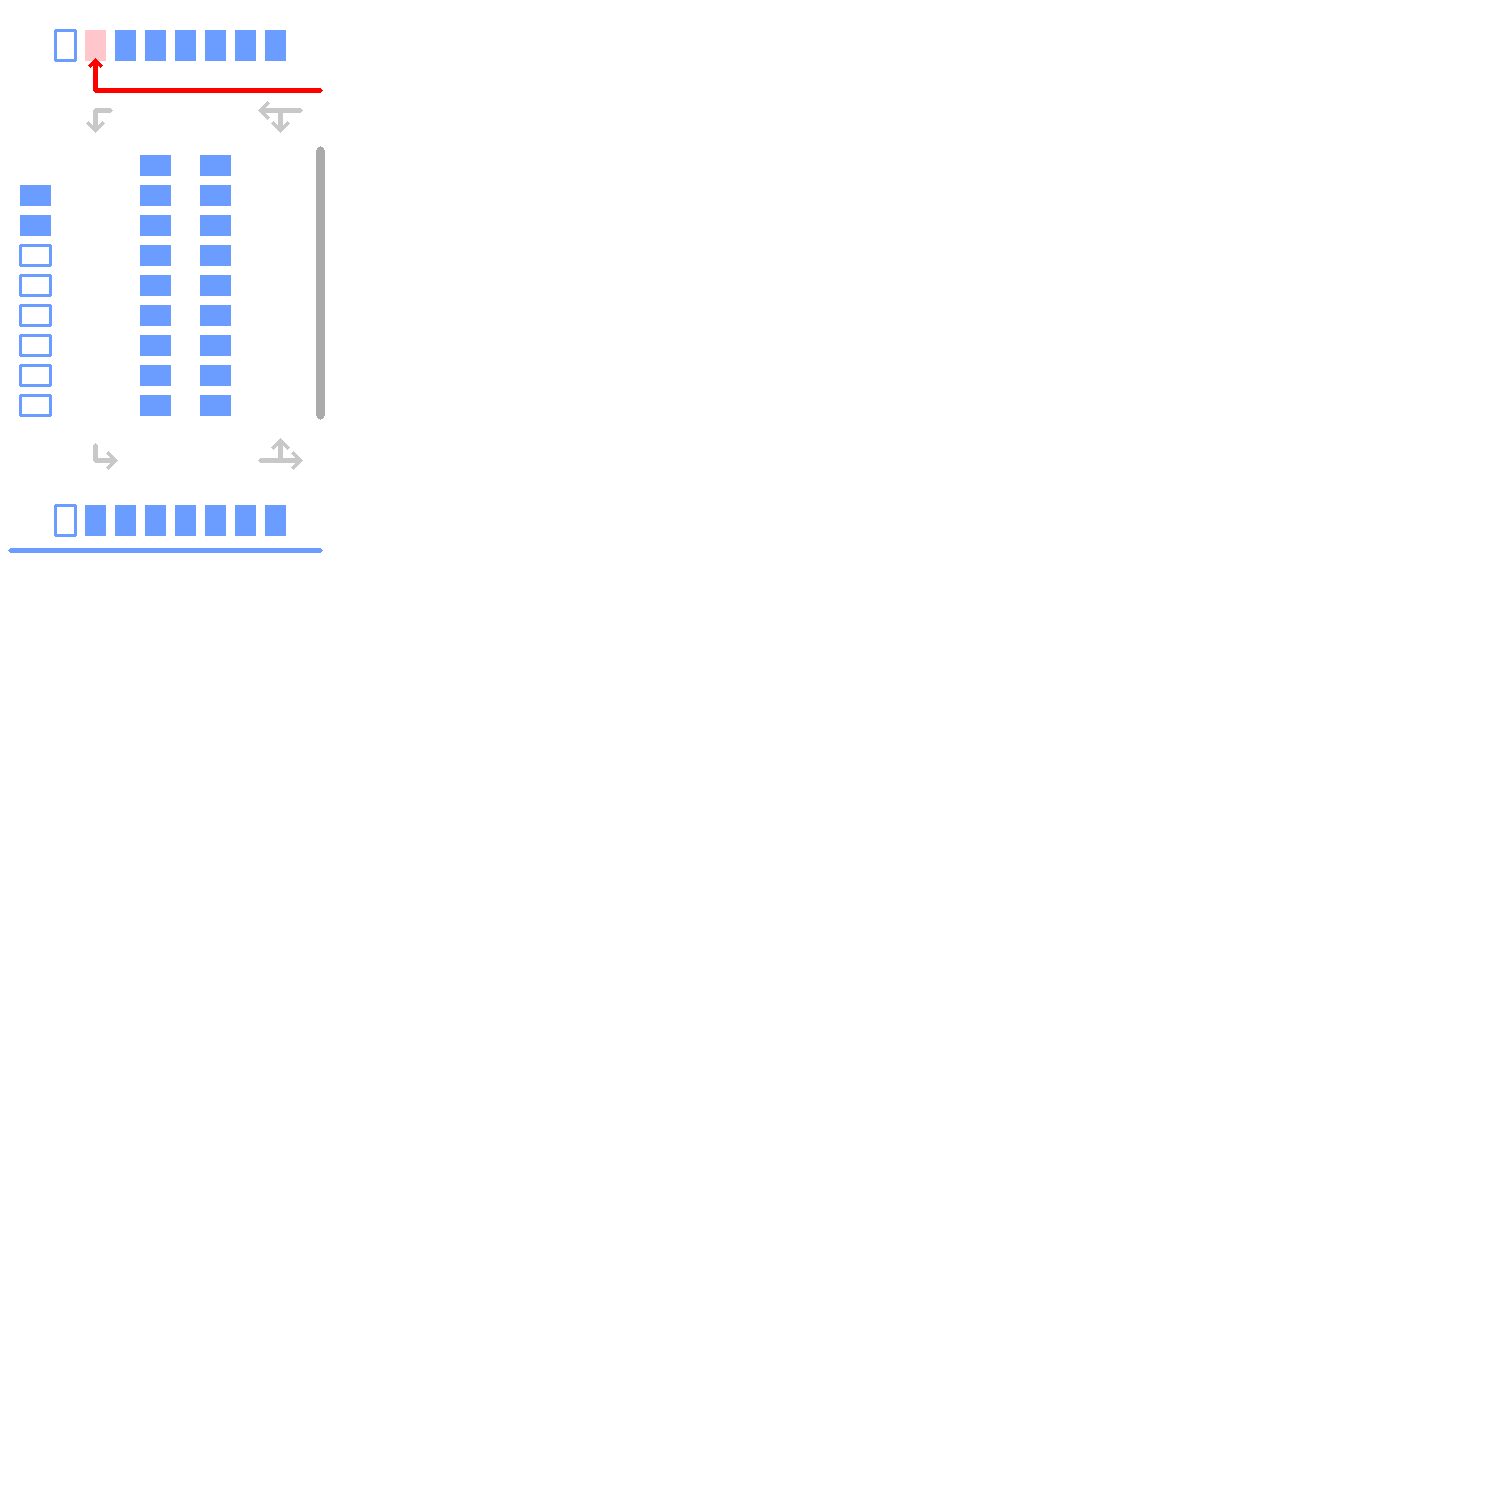

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 28.9ms
Speed: 0.4ms pre-process, 28.9ms inference, 1.4ms NMS

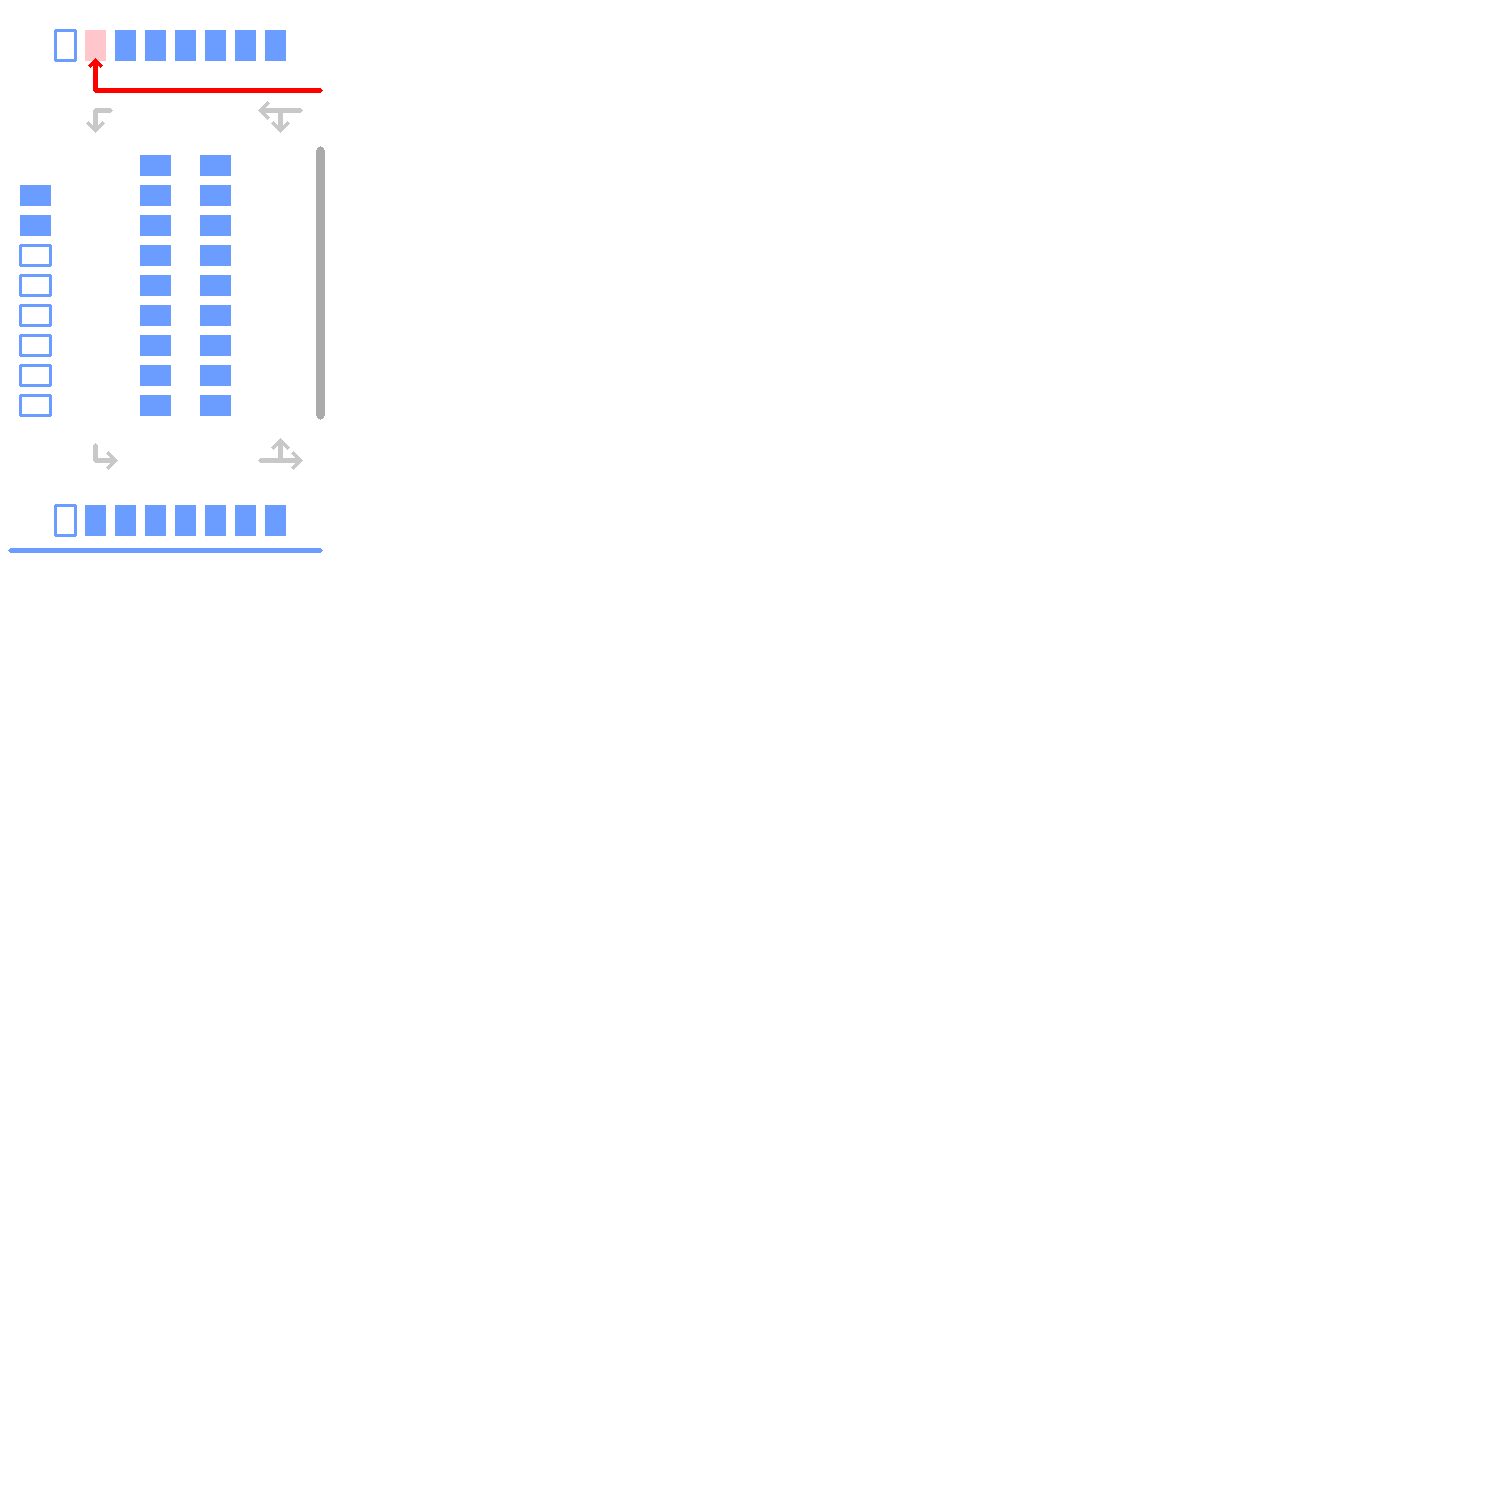

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 29.0ms
Speed: 0.3ms pre-process, 29.0ms inference, 1.9ms NMS

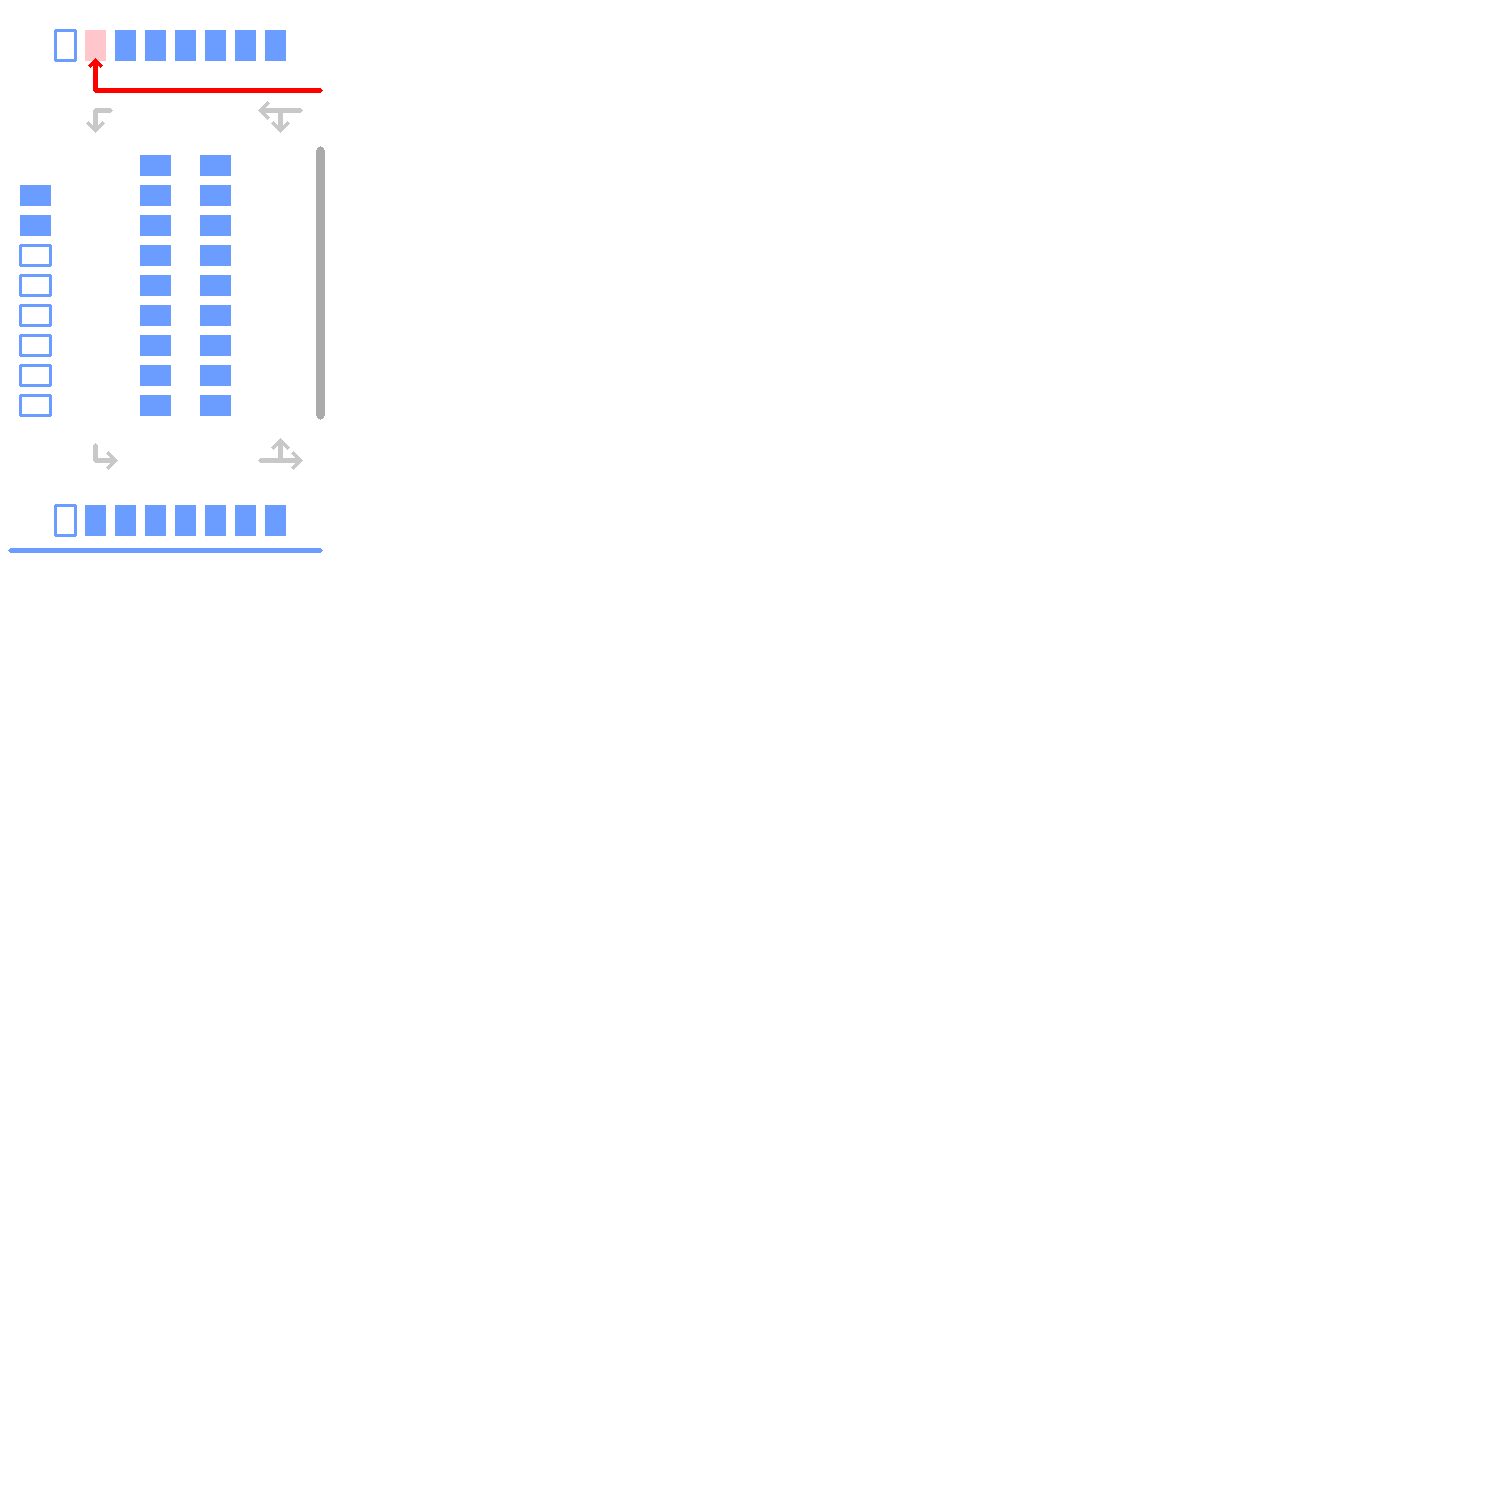

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 29.0ms
Speed: 0.4ms pre-process, 29.0ms inference, 1.4ms NMS

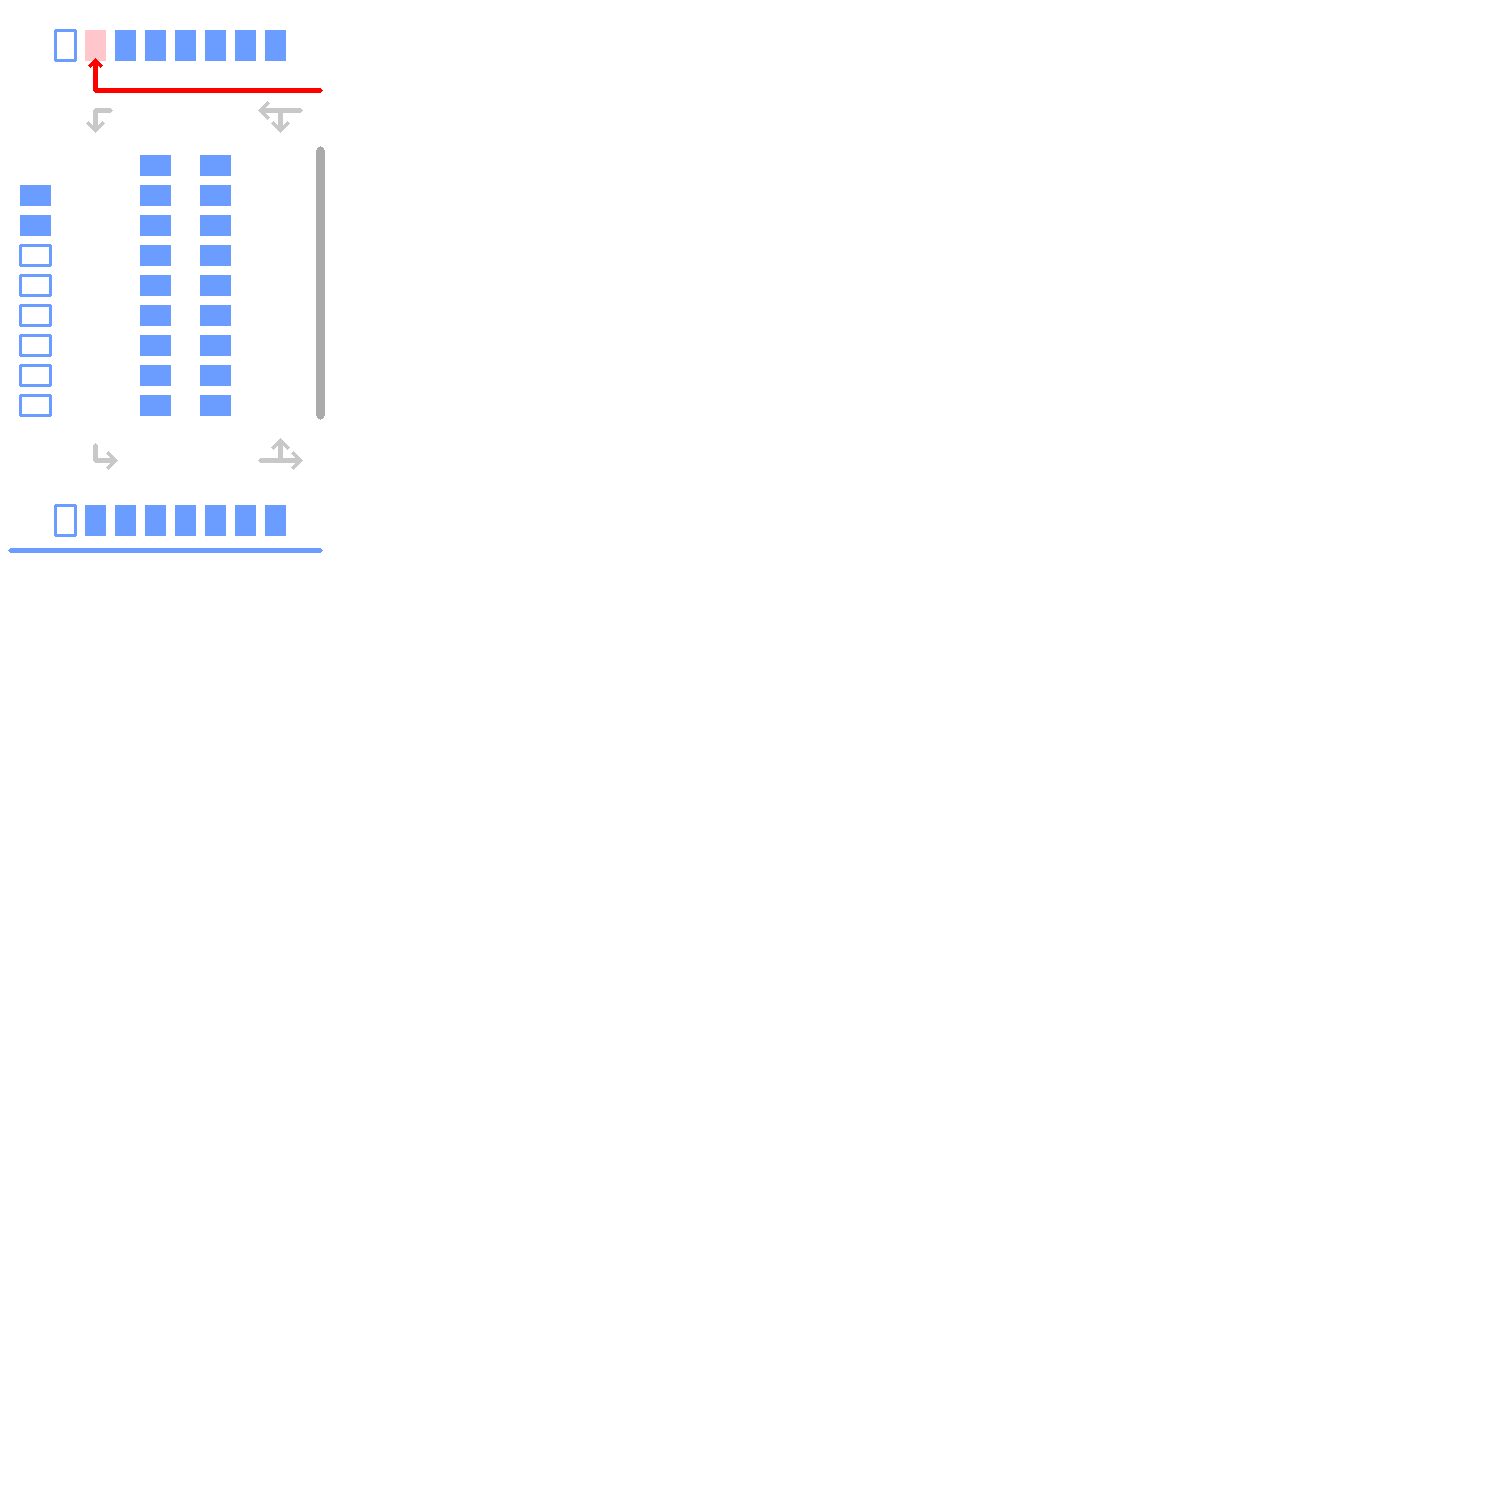

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 29.1ms
Speed: 0.3ms pre-process, 29.1ms inference, 1.4ms NMS

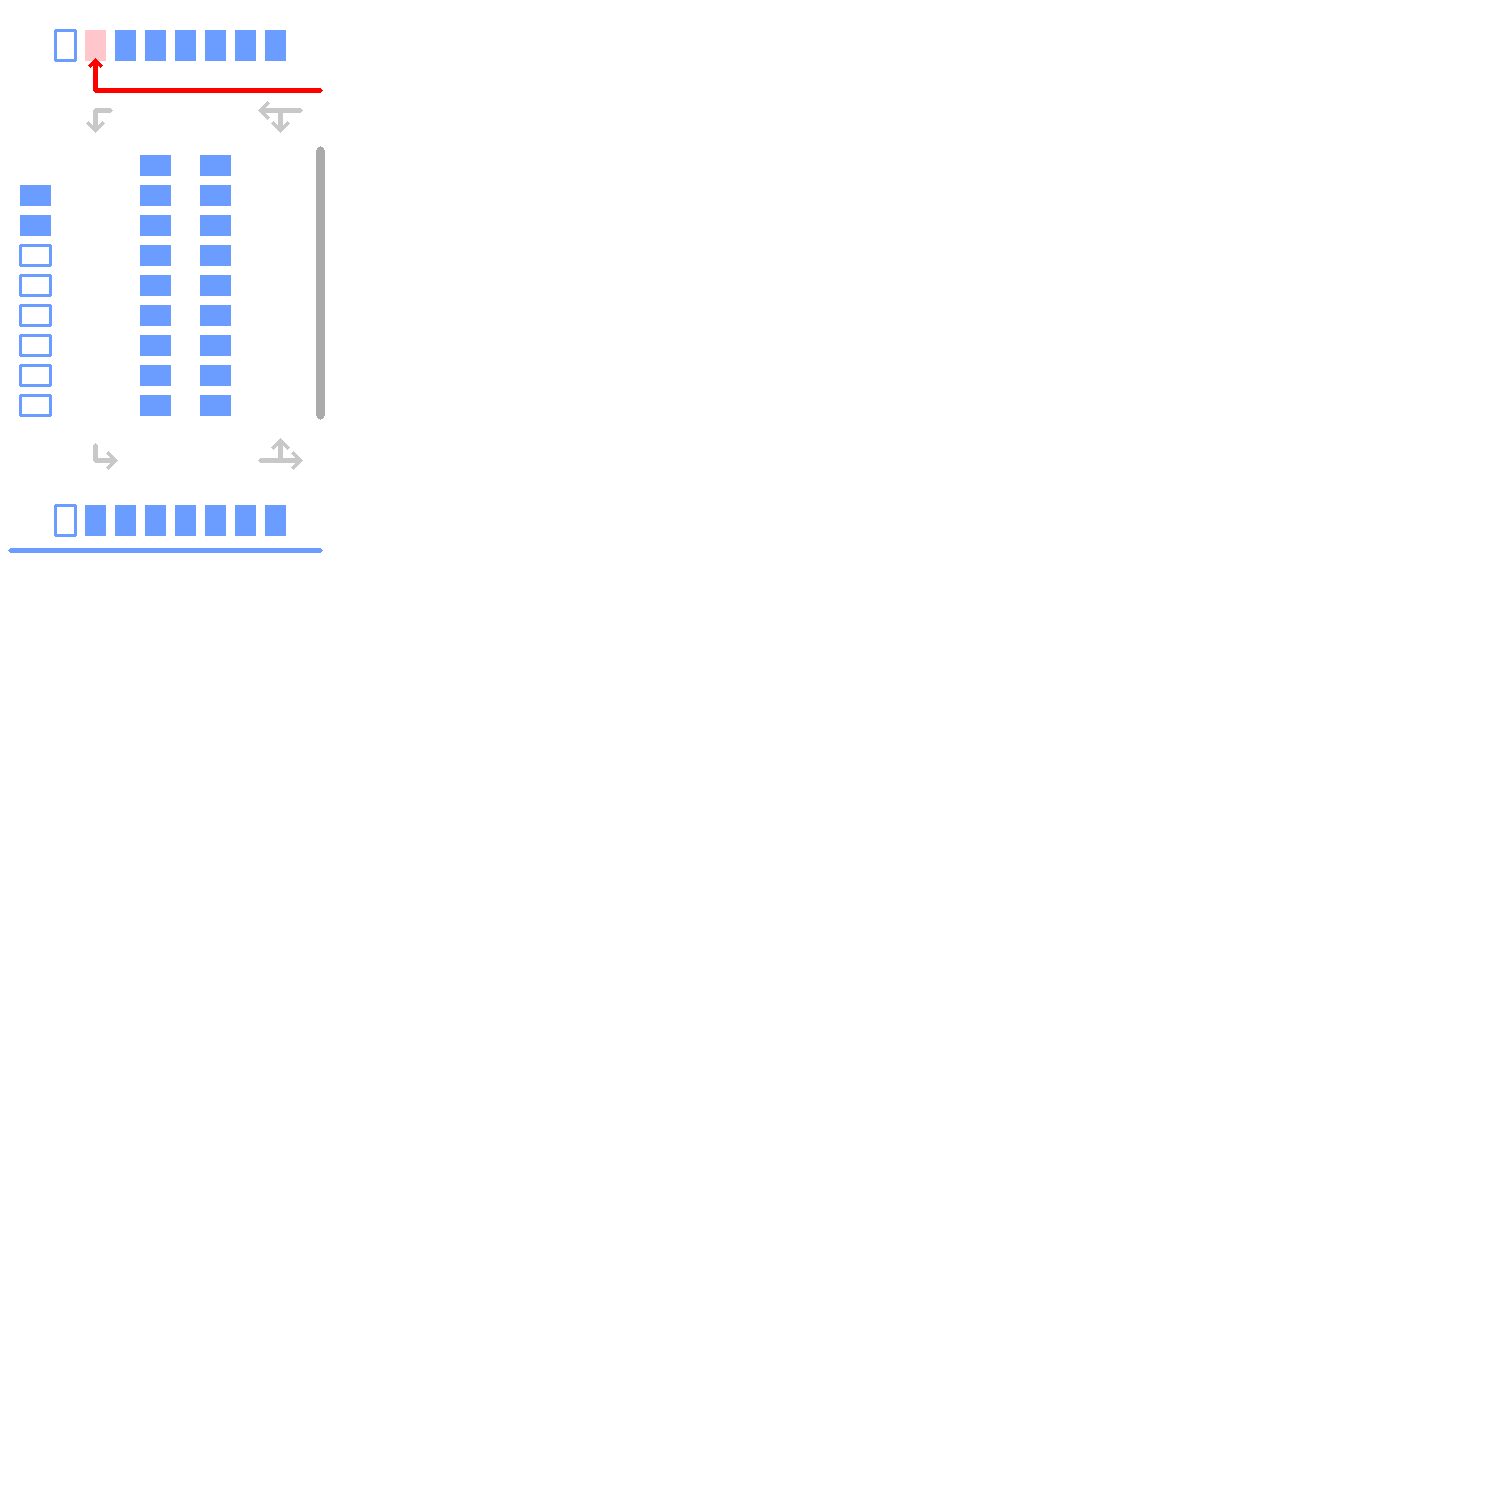

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 28.9ms
Speed: 0.3ms pre-process, 28.9ms inference, 1.5ms NMS

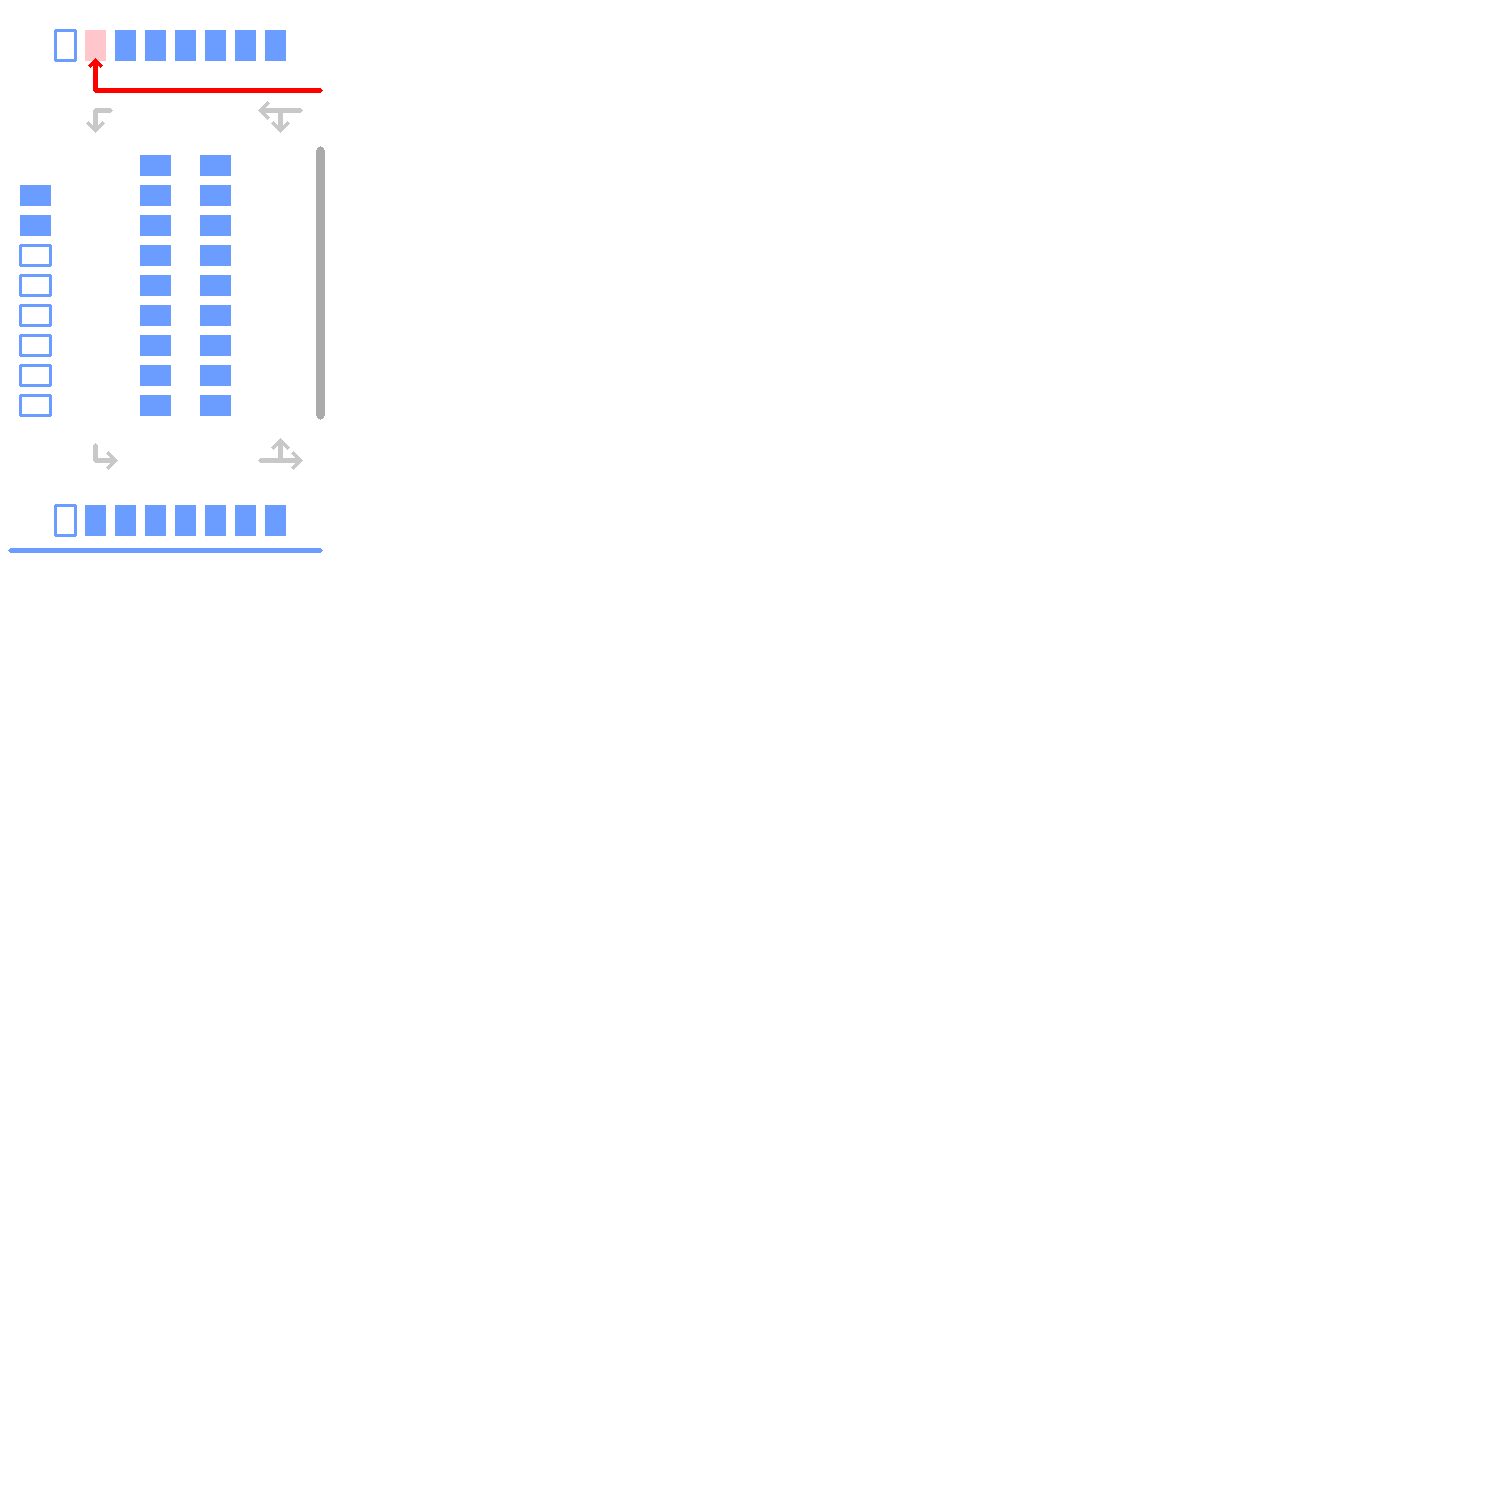

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 28.9ms
Speed: 0.4ms pre-process, 28.9ms inference, 1.5ms NMS

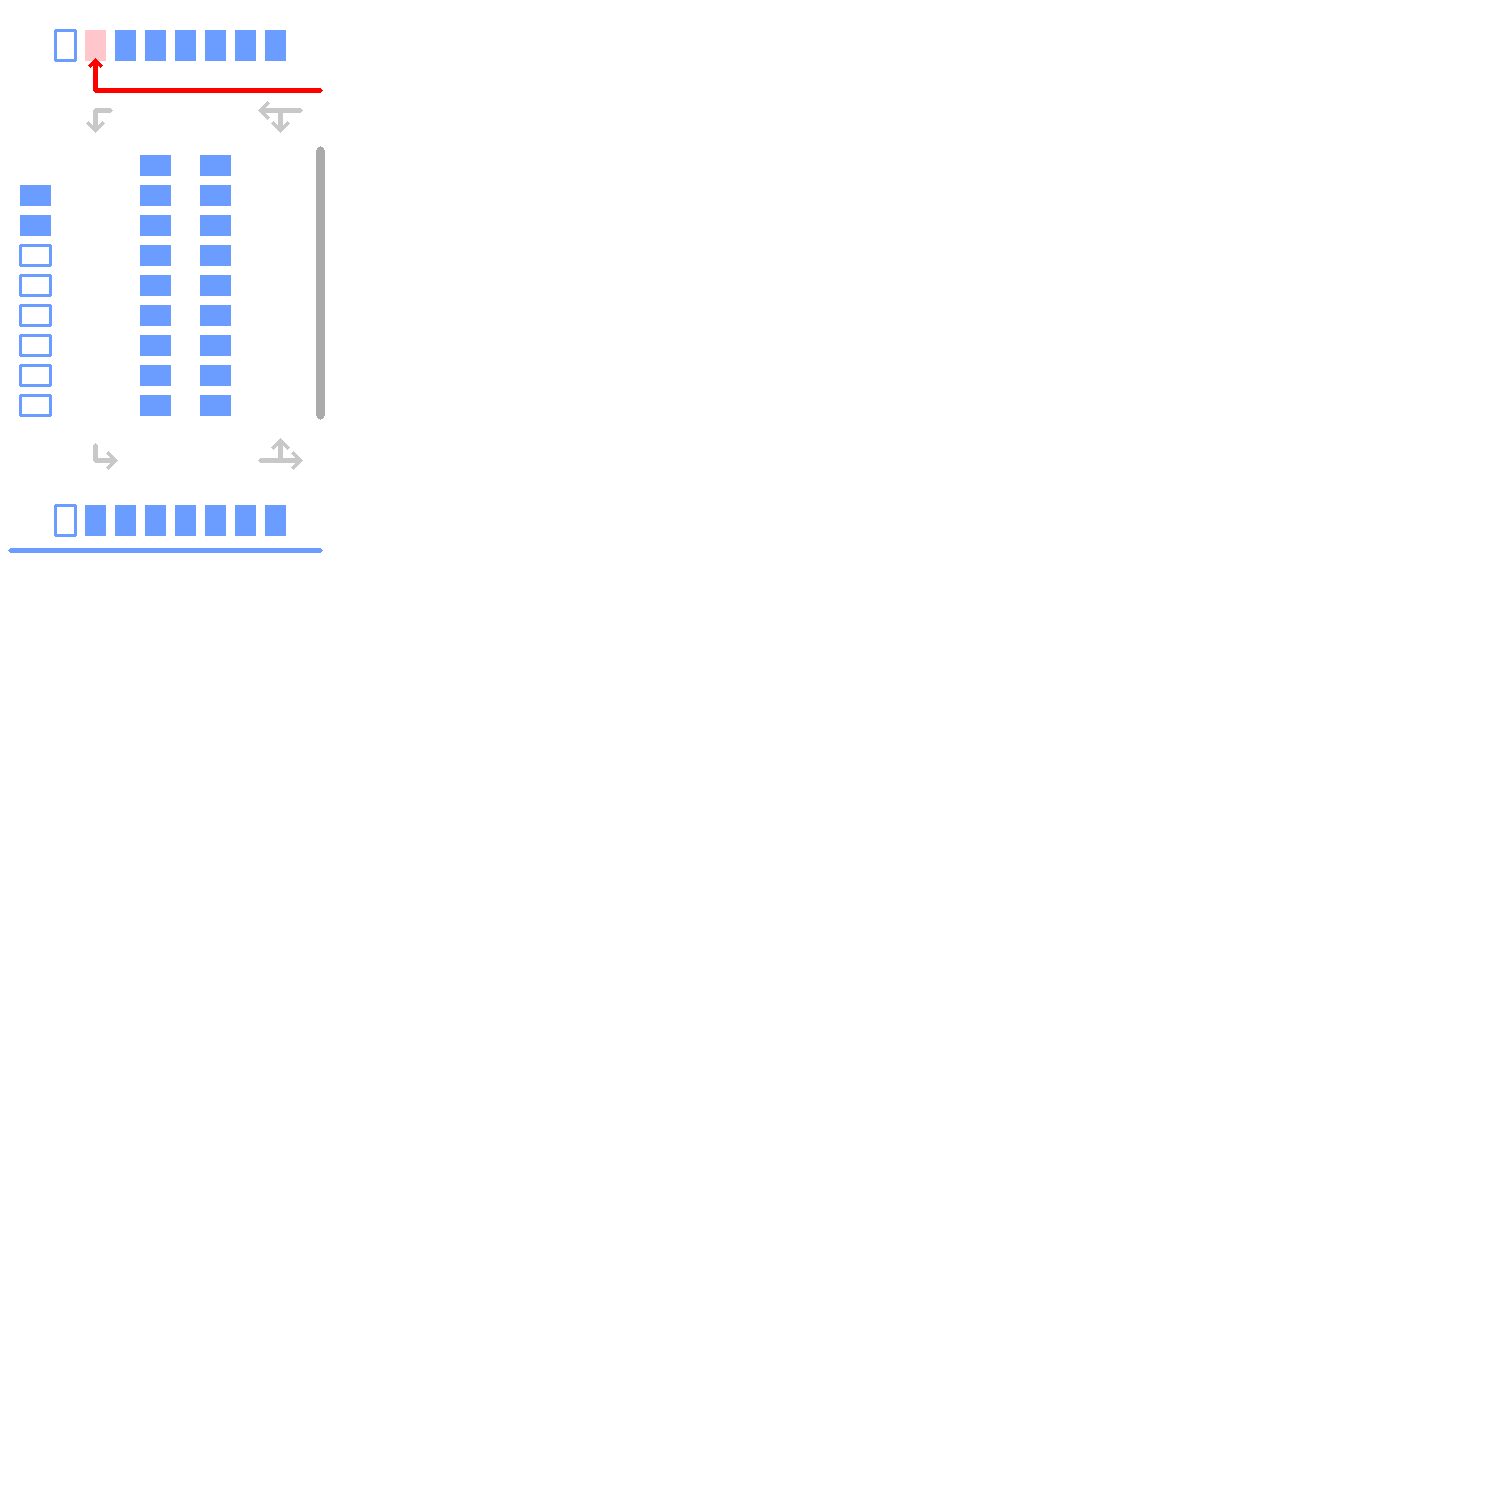

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 28.9ms
Speed: 0.3ms pre-process, 28.9ms inference, 1.4ms NMS

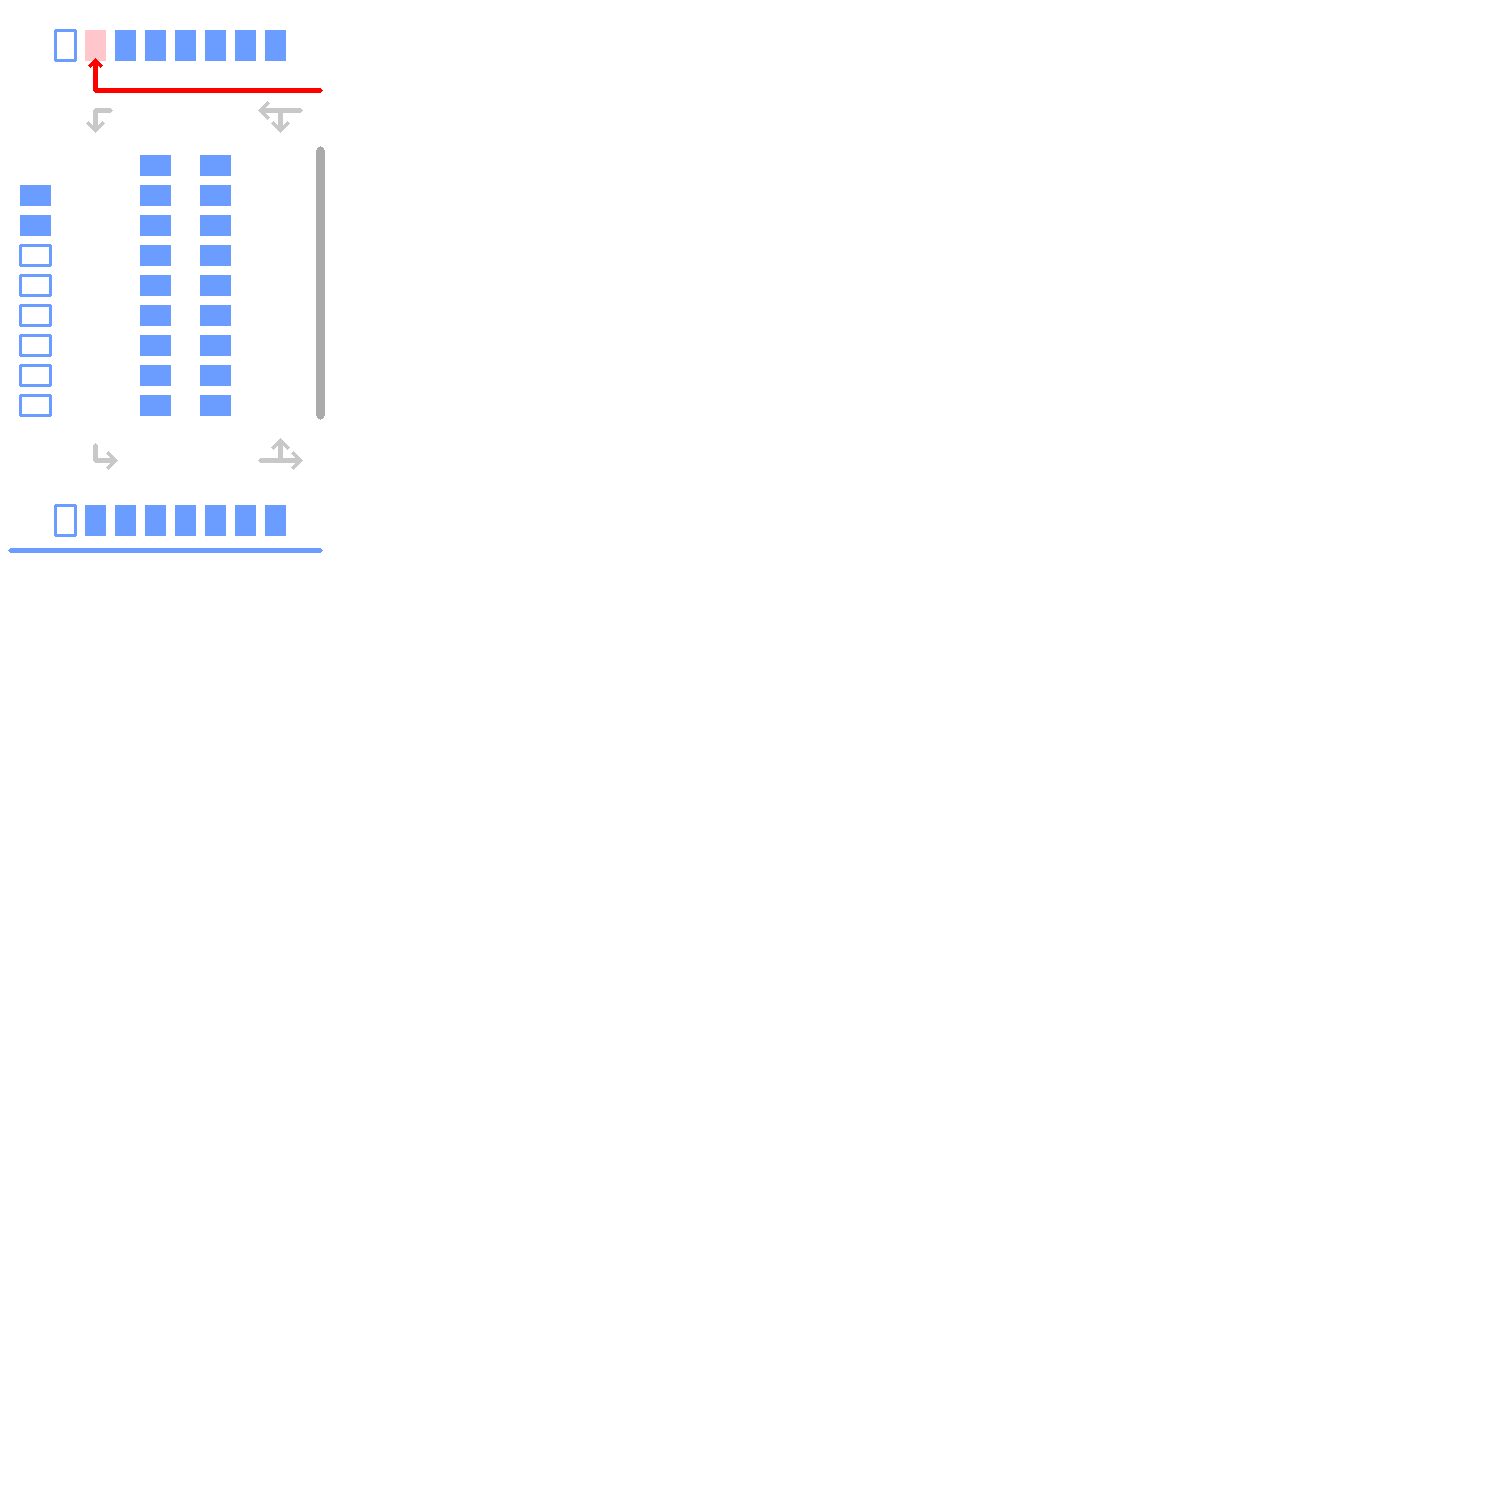

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 28.9ms
Speed: 0.4ms pre-process, 28.9ms inference, 1.5ms NMS

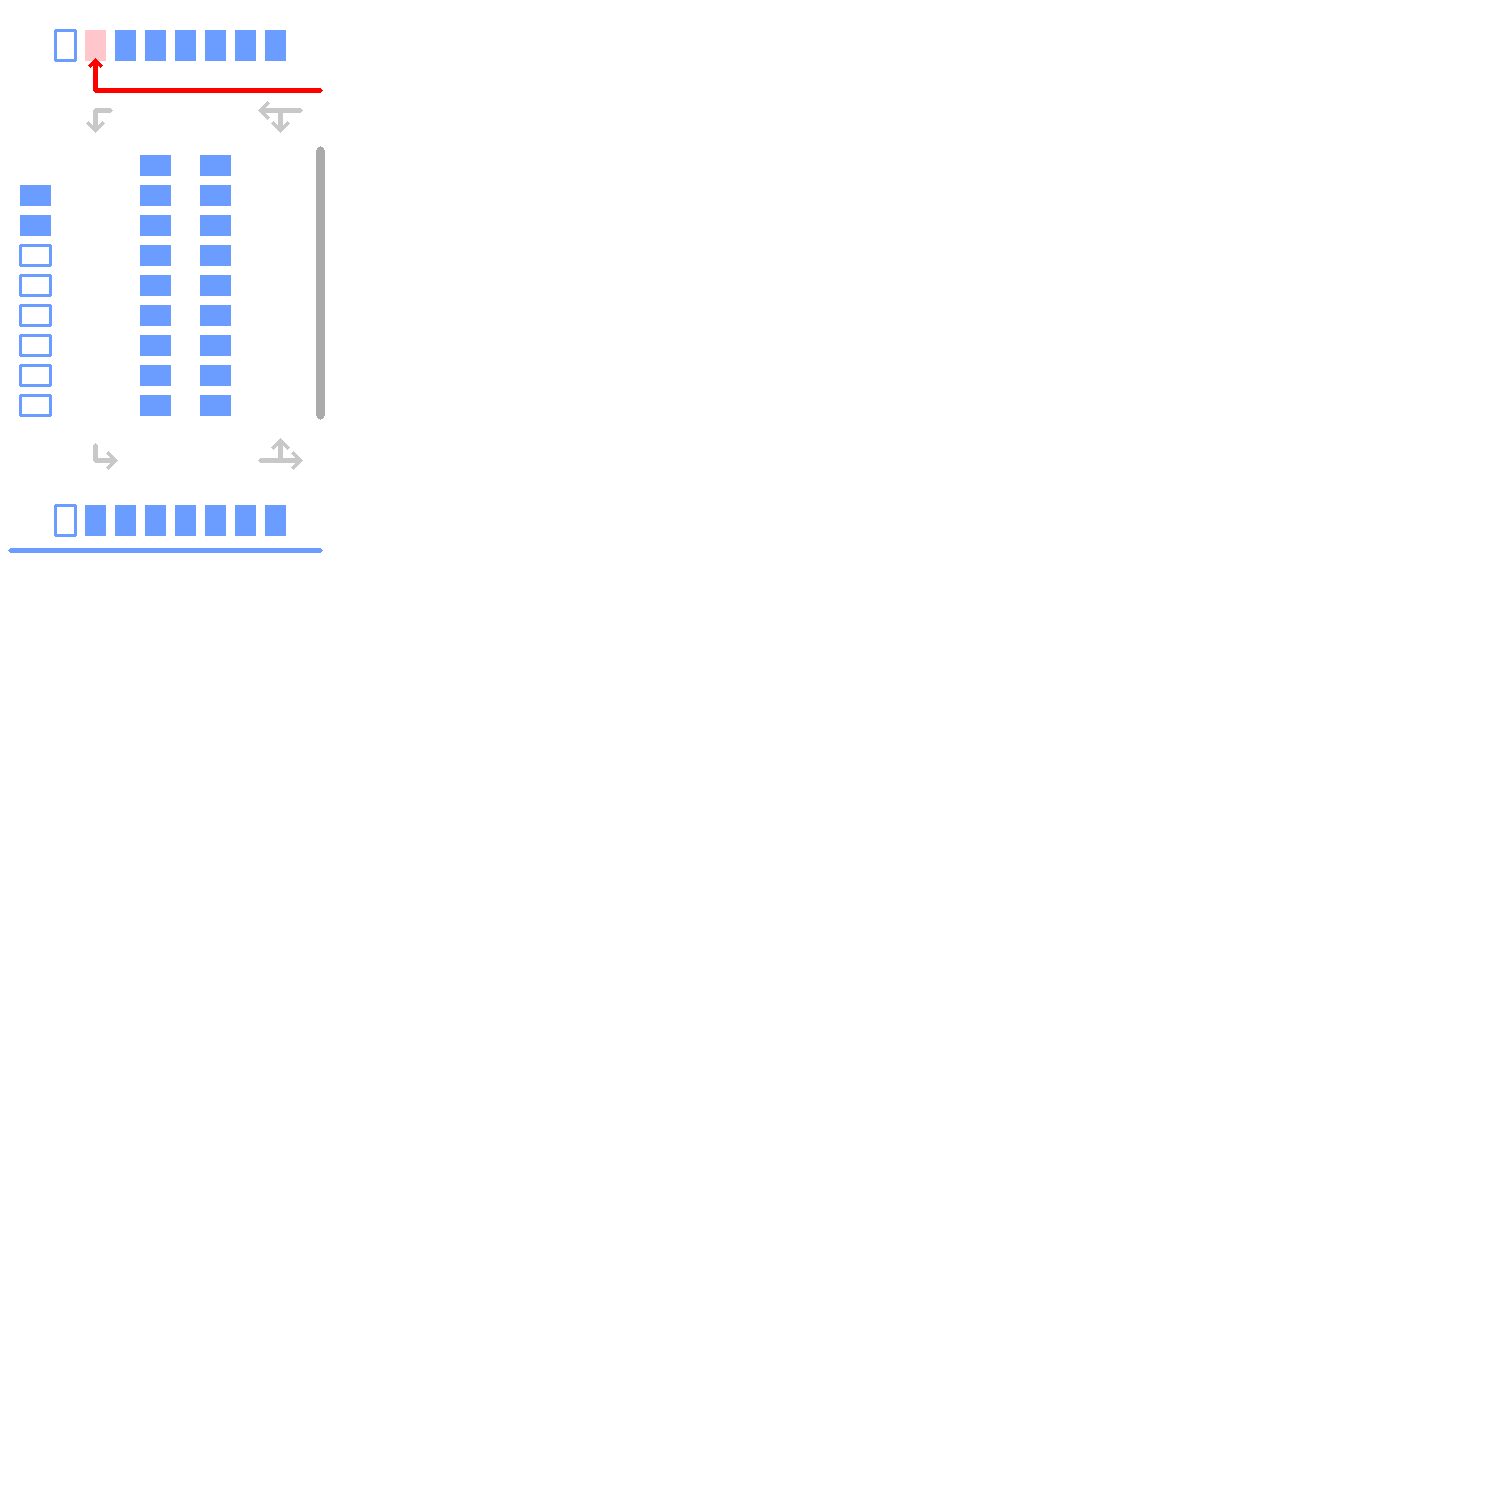

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 28.9ms
Speed: 0.3ms pre-process, 28.9ms inference, 1.4ms NMS

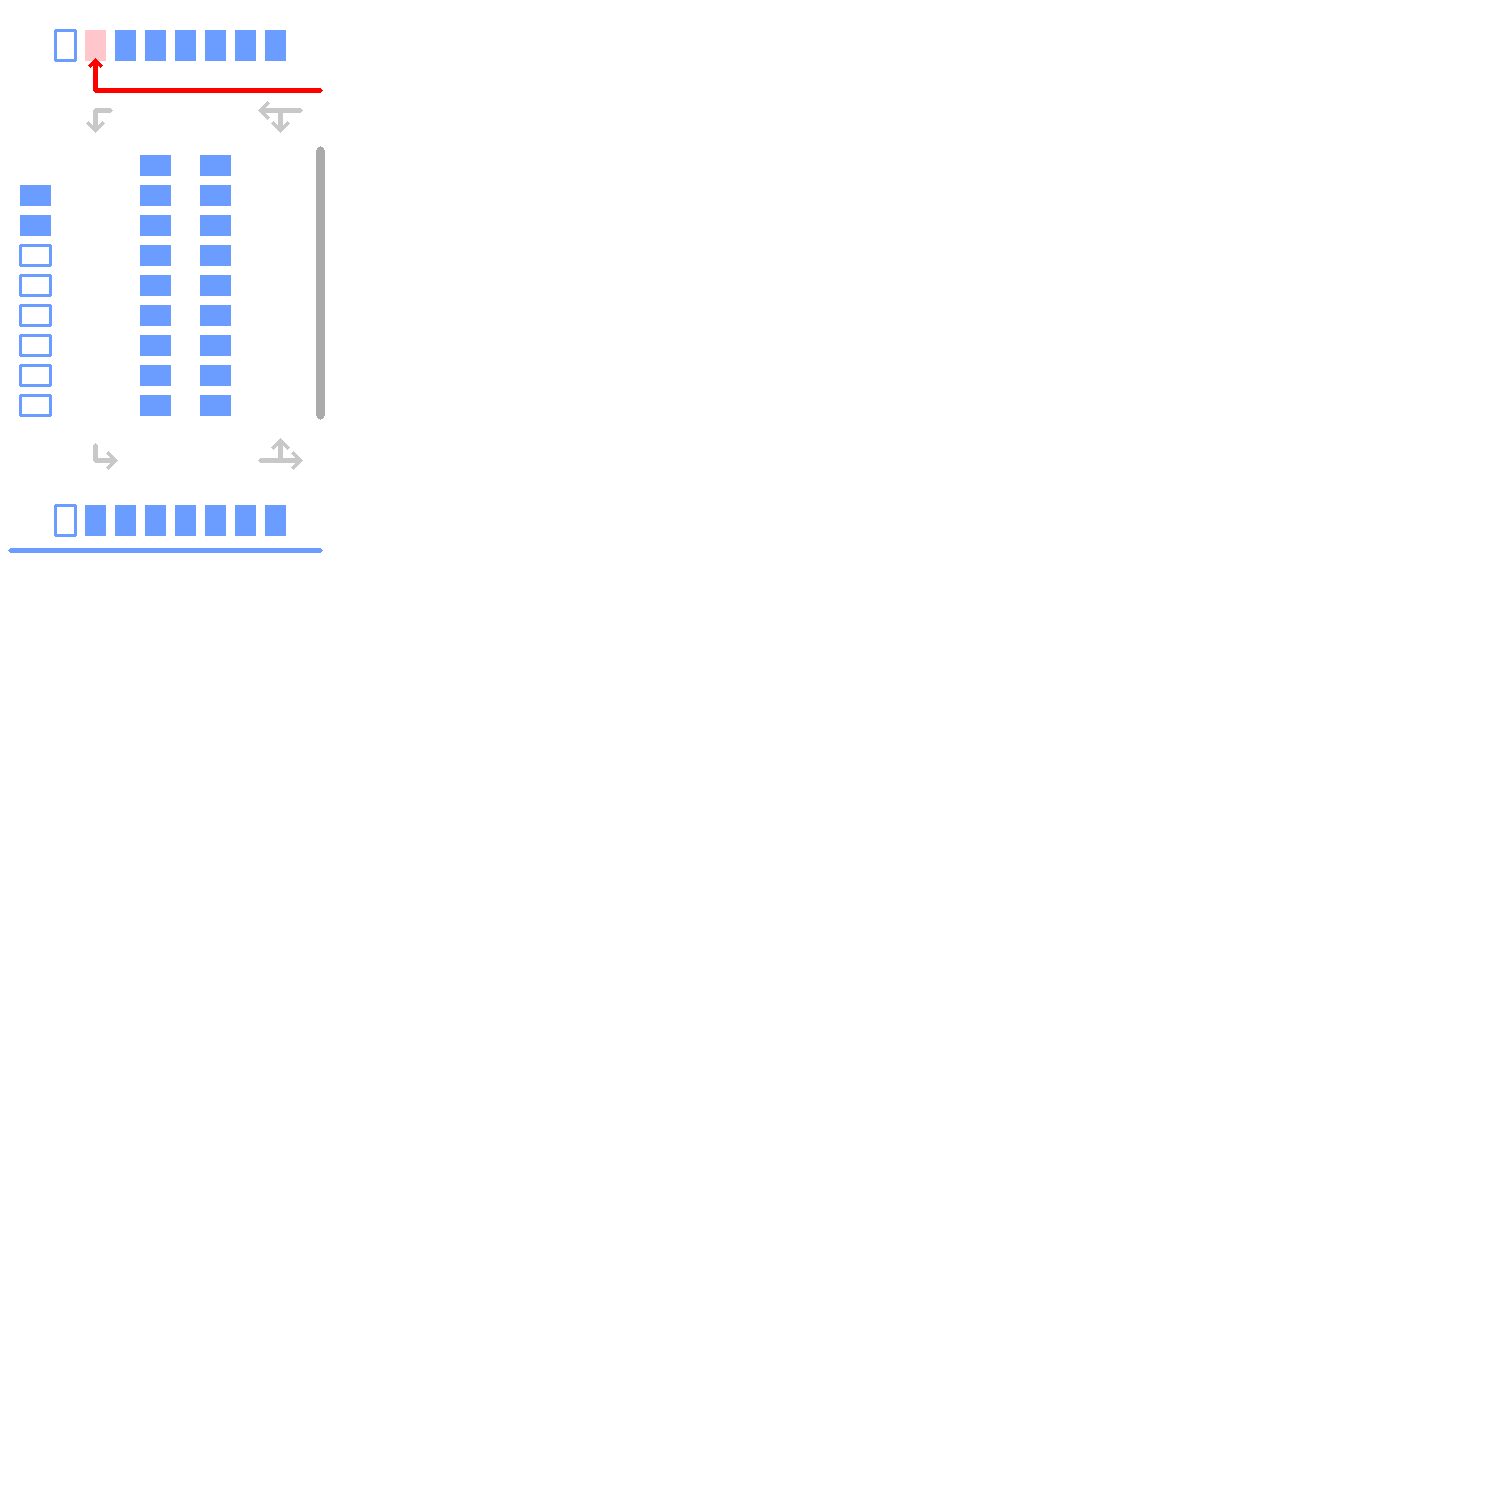

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 28.9ms
Speed: 0.2ms pre-process, 28.9ms inference, 1.4ms NMS

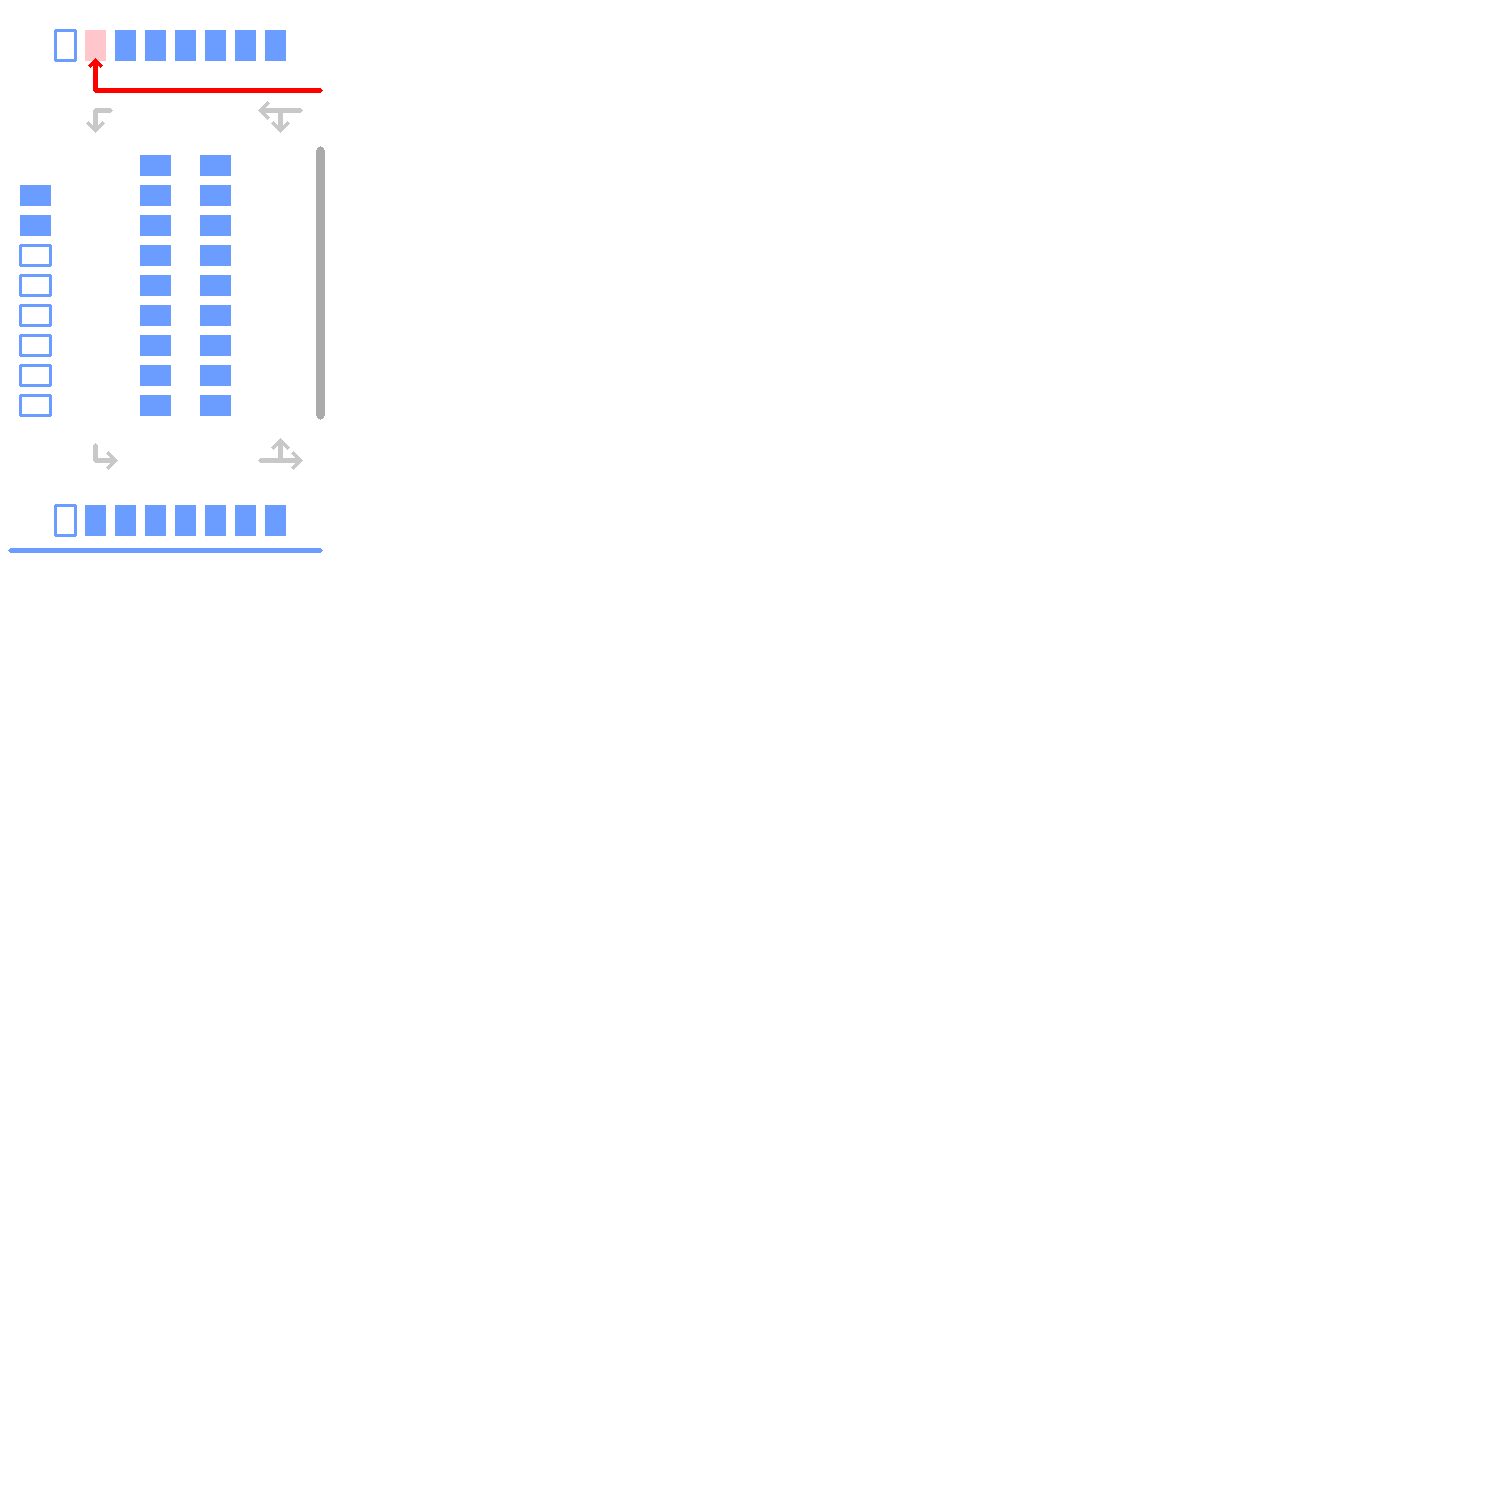

Success
redirect:/upload_file
detect: weights=['/content/drive/MyDrive/yolov5/runs/train/result4/weights/best.pt'], source=/content/drive/MyDrive/주차장/Images/001_H.jpg, data=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/.shortcut-targets-by-id/14F19gWzXroQbOu5n67dpWEG6-CDVb-V8/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86180143 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/주차장/Images/001_H.jpg: 192x320 4 1s, 28.9ms
Speed: 0.3ms pre-process, 28.9ms inference, 1.4ms NMS

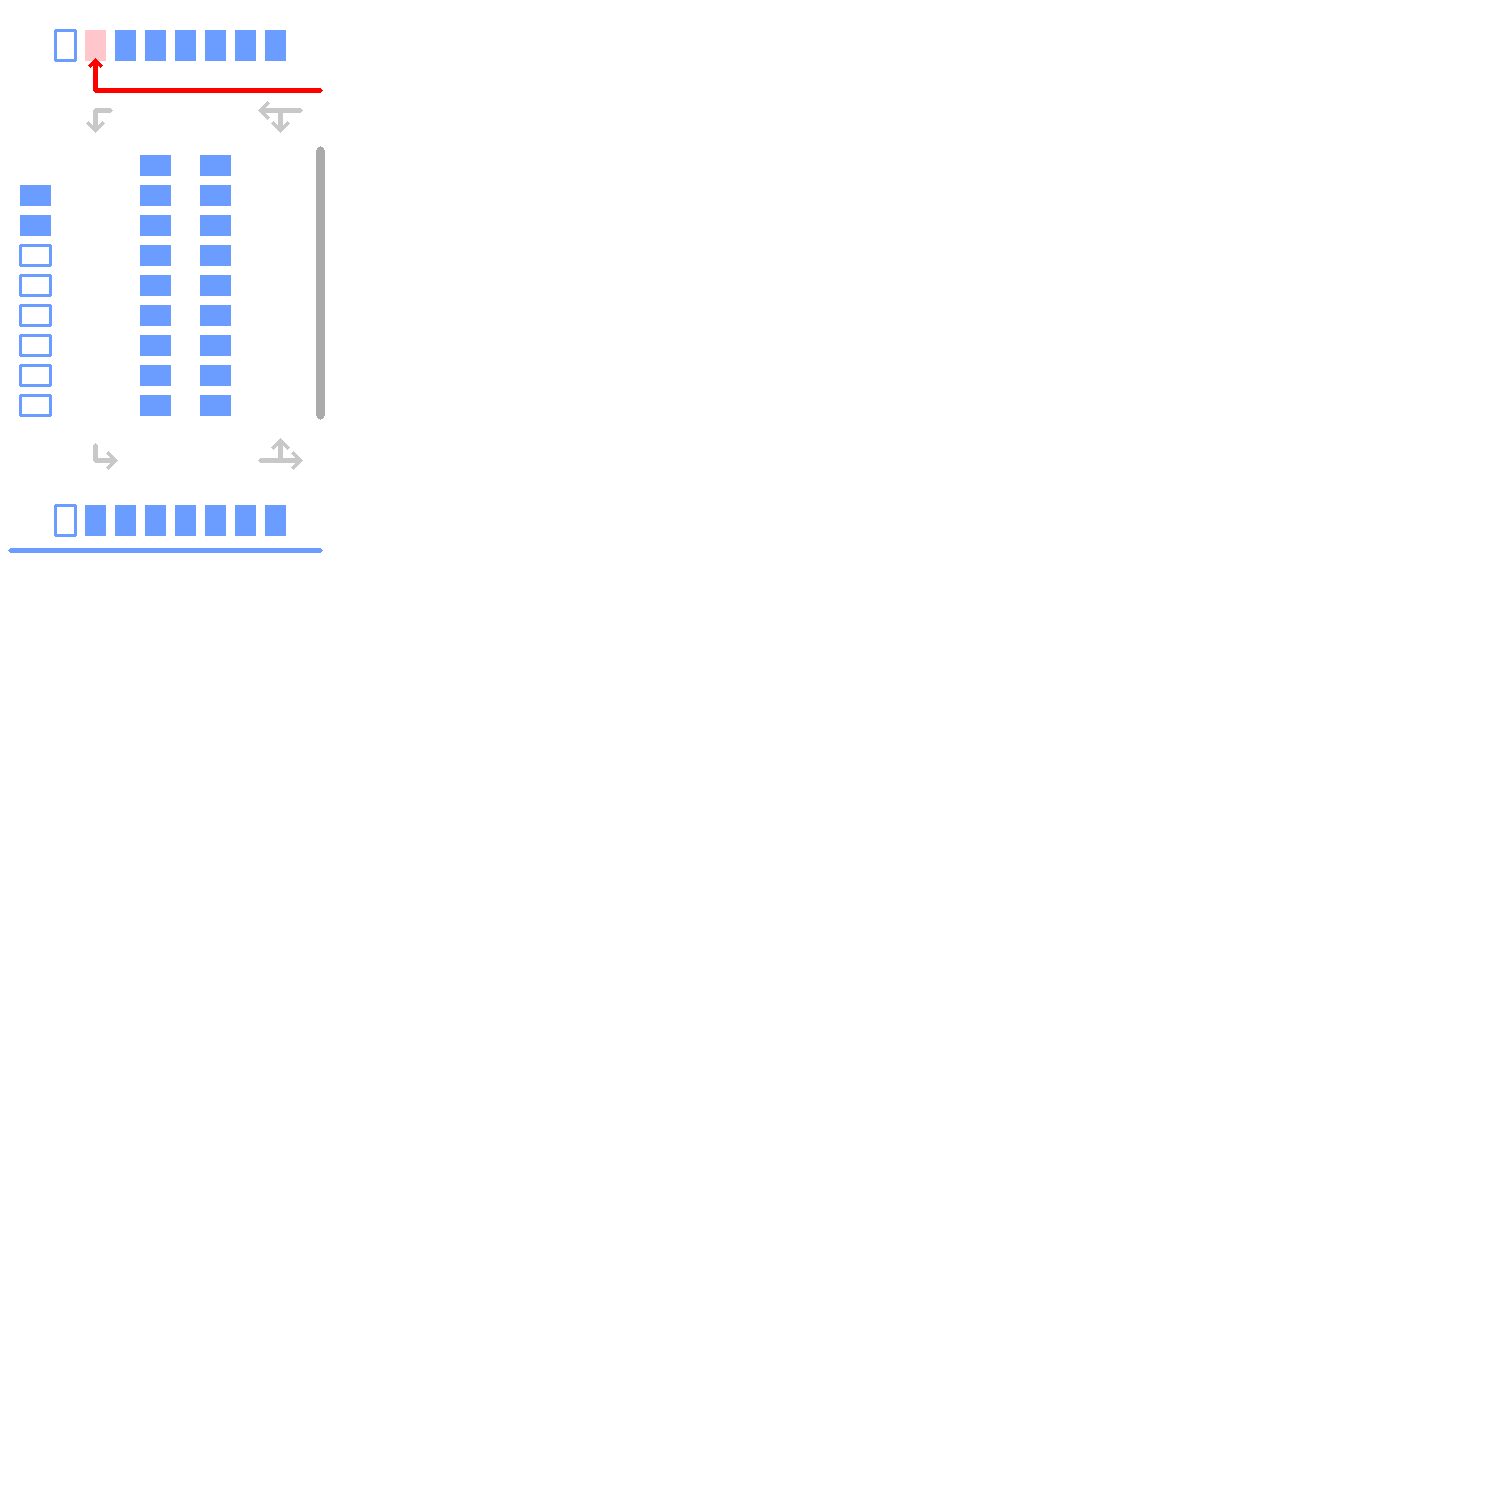

Success
redirect:/upload_file
new {'client': 'owner_1_token', 'name': 'parkingLot_1', 'address': 'parkingLot_1_address', 'latitude': 12.3, 'longitude': 45.6, 'cars': [], 'numberOfCars': 0, 'id': 1}
new {'client': 'owner_2_token', 'name': 'parkingLot_3', 'address': 'parkingLot_3_address', 'latitude': 12.3, 'longitude': 45.6, 'cars': [], 'numberOfCars': 0, 'id': 3}
new {'client': 'owner_1_token', 'name': 'parkingLot_1', 'address': 'parkingLot_1_address', 'latitude': 12.3, 'longitude': 45.6, 'cars': [], 'numberOfCars': 0, 'id': 10}
new {'client': 'owner_2_token', 'name': 'parkingLot_2', 'address': 'parkingLot_2_address', 'latitude': 12.3, 'longitude': 45.6, 'cars': [], 'numberOfCars': 0, 'id': 11}
new {'client': 'owner', 'name': 'sample', 'address': 'address', 'latitude': 123.0, 'longitude': 123.0, 'cars': [], 'numberOfCars': 0, 'id': 12}
new {'client': 'owner', 'name': 'sample', 'address': 'hi', 'latitude': 1231.0, 'longitude': 123.0, 'cars': [], 'numberOfCars': 0, 'id': 13}
new {'client

KeyboardInterrupt: ignored

In [9]:

def init_variable():
  global map, tmp_map, parking_map, comment, rowSize, colSize, startX, startY, parkingPlace, road, emptyFlag, direction, numOfPP, ppIdx, dx, dy, visit, initialBox, mappingBox, cntPP
  map = [['z' for col in range(1001)] for row in range(1001)]
  tmp_map = [['z' for col in range(1001)] for row in range(1001)]
  parking_map = [[["z" for idx1 in range(1001)] for idx2 in range(1001)] for idx3 in range(100)]
  comment = ["none" for idx in range(1001)]
  rowSize = 0; colSize = 0;
  i = 0; j = 0;
  #입구 위치
  startX = 0; startY = 0;
  #주차 공간 정보
  parkingPlace = [DOT() for idx in range(1001)]
  road = [list() for idx in range(1001)]
  emptyFlag = ['z' for i in range(1001)] # "a"면 빈칸 "A"면 차있는 칸
  direction = ['z' for i in range(1001)]
  numOfPP = 0
  ppIdx = 0
  dx = [1,-1,0,0]
  dy = [0,0,1,-1]

  visit = [[0 for col in range(1001)]for row in range(1001)]

  #초기 디텍팅박스 좌표 정보
  #initialBox = []
  #initialBox.clear()
  #mappingBox = []
  mappingBox.clear()

  #cctv 담당 구역 개수(초기 정보)
  cntPP  = [4,4,4,4,4,4,5,4,5,4]


test_img = glob.glob('/content/drive/MyDrive/주차장/Images/*.jpg')+glob.glob('/content/drive/MyDrive/주차장/Images/*.jpeg')
dir = '/content/drive/MyDrive/drowing/**'
filelist = glob.glob(dir, recursive = True)
file_list = [file for file in filelist]
print('file_list',file_list)
pList=[]
def check_draw():
  newDraw = []
  #백엔드에서 owner(설계도)가 있는 주차장 리스트를 받아온다
  res = requests.get(url+"/get_all_registered_parking_lot_info")
  if res.status_code == 200:
    pList=json.loads(res.content)
    print('주차장 목록(owner 있는 등록된 주차장)\n',pList)
    print('pList', pList)
    for p in pList:
      # 드라이브에 있는 이미지 불러오기(CCTV촬영값이라고 치자)
      # 이미지 이용해서 비전 디텍팅
      # 결과값 이미지가 나오면
      #위에가 다 한 함수였음 좋겠어요 그래가지구 완성된 이미지를
      #이미지를 p['id']_1_1_A.jpg형식에 맞춰서 전송 폴더에 저장해놓으면 아래 코드에 의해 전송이됩니다!
      #함수호출
      # make_navi(p)
      section = 'A'
      fileType=3 #CCTV사진이라는 뜻
      CCTVID=1
      #initialBox가 초기화가 안됨
      #print("initialBox : ", initialBox)
      construct_img(p, section)     

      dir = '/content/drive/MyDrive/yolov5/runs/detect/'
      filelist = glob.glob(os.path.join(dir,"*"))
      for f in filelist:
        shutil.rmtree(f)

      files = {'uploadFile': open('/content/drive/MyDrive/주차장/전송/'+str(p['id'])+'_'+str(fileType)+'_'+str(CCTVID)+'_'+section+'.jpg','rb')}
      r=requests.post(url+'/upload_file',files=files, params={'parkingLotID':p['id'], 'fileType':fileType, 'CCTVID':CCTVID,'section':section})
      check_res(r)
      
    # 여기는 설계도면 갱신하는 부분분
    if len(filelist) < len(pList):
      for p in pList:
        if p['name']+str(p['id'])+'.jpg' not in file_list:
          print('new',p)
          # 설계도 폴더에 [주차장이름 + id].jpg로 적용
          down_img = requests.get(url+"/download",params={'parkingLotID':p['id'], 'fileType':4, 'section':'A'}) 
          save_img = open('/content/drive/MyDrive/drowing/'+p['name']+'_'+str(p['id'])+'.jpg','wb')
          save_img.write(down_img.content)
          save_img.close()

          newDraw.append(p['name']+str(p['id'])+'.jpg')
  else:
    print(res.text)


  return newDraw

def send_email(maildata):
  smtp = smtplib.SMTP('smtp.gmail.com', 587)

  smtp.ehlo()

  smtp.starttls()
  smtp.login('dltjrkd6@gmail.com', 'bvfbwgsncdcjclxv')

  msg = MIMEText(maildata)
  msg['Subject'] = '새로운 주차장 설계도가 들어왔습니다.'

  smtp.sendmail('dltjrkd6@gmail.com', 'dltjrkd6@gmail.com', msg.as_string())

  smtp.quit()

time = dt.datetime.now()

while True:
  now = dt.datetime.now()
  
  #2초에 한 번씩 받아옴
  if now.second == time.second+2:
    init_variable()
    res  = check_draw()
    initialBox.clear()
    # 주차장 리스트에 변경사항이 있으면 == 추가된 주차장이 있으면 이미지를 drive/drowing에 넣어주고 담당자한테 메일 넣음
    if len(res) > 1:
      for draw in res:
        send_email(draw)
    time = now
